# Code to analyze data dn reproduce figures for Snow et al., in review 
## by Tasha Snow, PhD
#### Figures 2, 4, 6, 7, S2 bottom, S4, Table 1
#### Apr 9, 2023

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib widget
import re
import os

from glob import glob
from collections import OrderedDict

# from ctd import lp_filter, plot_section, movingaverage #DataFrame, Series, 
import gsw
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import pandas as pd
import netCDF4
import pickle
from netCDF4 import Dataset
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
from scipy import interpolate
import scipy.signal as signal
# import pyodv
# import cotede
# import iris
# import datetime
import cmocean
from datetime import datetime,timedelta
import numpy.ma as ma
from astropy.time import Time
from astropy.time import TimeDelta
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels.graphics import tsaplots

import seaborn as sns
import scipy.io as spio
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from sklearn import gaussian_process
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy.fftpack import fft
from cycler import cycler
from matplotlib.pyplot import cm
from matplotlib.pylab import rcParams
import matplotlib.gridspec as gridspec
rcParams['contour.negative_linestyle'] = 'solid' 
sns.set_style('ticks')
rcParams['figure.figsize'] = 8, 4
rcParams['figure.frameon'] = True

In [2]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

In [3]:
def alphanum_key(s):
    key = re.split(r"(\d+)", s)
    key[1::2] = map(int, key[1::2])
    return key

###############################

def get_dist(lon,lat,reverse=False): #data,
#     lon, lat, data = list(map(np.asanyarray,(lon, lat, data)))
#     data = ma.masked_invalid(data)
    if reverse:
        lon = lon[::-1]
        lat = lat[::-1]
#         data = data.T[::-1].T
#         h = h[::-1]
    lon, lat = map(np.atleast_2d, (lon, lat))
    x = np.append(0, np.cumsum(gsw.distance(lon, lat)[0] / 1e3))
    return x

#########################################

def setup_moor(dataset, binsize=[0.01,4], mainx='Hours', kind='interp'):
    '''
    Sets up grids for transect plot. Extracts bathymetry for plot. Grids and interpolates temperature, salinity, density, 
    and whichever data hasn't been used as the x-axis for the geostrophy.
    
    Parameters
    ----------
    dataset = DataFrame of temperature with depth index
    binsize = desired [x,y] binsize to grid and interpolate to
    kind = 'interp' (1D interpolation across grid) or 'krig' (kriging) method for interpolating to across grid
    
    Returns
    -------
    xi = x-axis values; lat, lon or distance
    yi = y-axis values; depth or pres usually
    zS = salinity 2D numpy grid
    zT = temperature 2D numpy grid
    zD = density 2D numpy grid
    zOther = either Lat or Lon 2D numpy grid, opposing variable of mainx
    maincol = string name of dimension for x-axis; lat, lon, or distance
    
    If select 'krig', also returns:
    ssS = error in zS from kriging
    ssT = error in zT from kriging
    ssD = error in zD from kriging
    ssOther = error in zOther from kriging
    '''

    # Create grid with linear interpolation
    # Swapped x and y as datasets so interpolation would happen along y, but swapped back in gridocean output
    # Need to transpose all data coming out of this
    if kind=='interp':
        y = dataset[mainx]
        x = dataset['Depth']

        # Creating grid for .1 degree longitude binning and 1m vertical depth 
        z = dataset['Temperature [C]']
        zT, yi, xi = gridocean(x, y, z, binsize=binsize,interp=True,retbin=False, retloc=False) 
        
        # Transpose since is currently in y,x and needs to be x,y
        return xi.T,yi.T,zT.T

    # Create grid with kriging for interpolation
    elif kind=='krig':
        try:
            del OKS, OKT, OKD, OKLon
        except:
            None

        # Create values for desired intervals of x and y
        xmin, xmax = dataset[mainx].min(), dataset[mainx].max()
        ymin, ymax = dataset['Depth'].min(), dataset['Depth'].max()
        xi = np.arange(xmin, xmax+binsize[0], binsize[0])
        yi = np.arange(ymin, ymax+binsize[1], binsize[1])
        
        # Creates interpolation surface then maps to new xi
        datasetn = dataset[dataset['Temperature [C]'].notnull()]
        OKT = OrdinaryKriging(datasetn[mainx], datasetn['Depth'], datasetn['Temperature [C]'], variogram_model='linear',verbose=False, enable_plotting=False)
        zT, ssT = OKT.execute('grid', xi, yi)
        
        return xi,yi,zT,ssT

#########################################

def plot_transect(ymin,ymax,xi,yi,zT,maincol,zlim,title=None):
    '''
    Plots transect for temperature and salinity with density contours and geostrophy. Includes markers of casts
    and bathymetry picked by max depth of casts or from a topo array. Inputs are the outputs from the setup transect
    function.
    ymin = top depth for y-axis of plot
    ymax = bottom depth for y-axis of plot
    xi = x-axis values; lat, lon or distance
    yi = y-axis values; depth or pres usually
    zT = temperature 2D numpy grid
    maincol = string name of dimension for x-axis; hours
    ##Dcontours = density contours to be plotted and labelled
    zlim = [temp lower, temp upper] limits for z-axis
    
    Returns
    -------
    Plot with T, S, and geostrophy transects
    ''' 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3),sharex=True)

    linewidth = 1.5

    a1 = ax
    a1.tick_params(labelsize=14)
    pc1 = a1.pcolor(xi,yi,zT, cmap=cmocean.cm.thermal, vmin=zlim[0], vmax=zlim[1])
#     cs = a1.contour(xi,yi,zD,Dcontours,colors='k',linewidths=0.5)
#     cs.levels = [nf(val) for val in cs.levels] # Recast levels to new class
#     a1.clabel(cs,cs.levels,inline=True, fmt=fmt, fontsize=10, colors='k')
#     a1.scatter(dataset[maincol].unique(),([-15]*dataset[maincol].unique().shape[0]),marker='v',s=15,c='white',edgecolors='k') # Plots markers for CTDs
    a1.set_ylim([ymin,ymax][::-1])
    # a1.set_xlabel('maincol)
    a1.set_ylabel('Depth [m]',fontsize=14)
#     a1.title.set_text(title)
    cbar = plt.colorbar(pc1,ax=ax)
    cbar.ax.tick_params(color='k',size=5,labelsize=14)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Temperature [C]', rotation=270,fontsize=14)

    return plt.tight_layout()
    
#########################################

def map_limits(m):
    llcrnrlon = min(m.boundarylons)
    urcrnrlon = max(m.boundarylons)
    llcrnrlat = min(m.boundarylats)
    urcrnrlat = max(m.boundarylats)
    return llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat

def make_map(llcrnrlon=-91.1, urcrnrlon=-87.5, llcrnrlat=27.5, urcrnrlat=29.5,
             projection='merc', resolution='i', figsize=(6, 6), inset=True):
    m = Basemap(llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon,
                llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,
                projection=projection, resolution=resolution)
    fig, ax = plt.subplots(figsize=figsize)
    m.drawstates()
    m.drawcoastlines()
    m.fillcontinents(color='0.85')
    meridians = np.arange(llcrnrlon, urcrnrlon + 2, 2)
    parallels = np.arange(llcrnrlat, urcrnrlat + 1, 1)
    m.drawparallels(parallels, linewidth=0, labels=[1, 0, 0, 0])
    m.drawmeridians(meridians, linewidth=0, labels=[0, 0, 0, 1])
    m.ax = ax

    if inset:
        axin = inset_axes(m.ax, width="40%", height="40%", loc=4)
        # Global inset map.
        inmap = Basemap(lon_0=np.mean(m.boundarylons),
                        lat_0=np.mean(m.boundarylats),
                        projection='ortho', ax=axin, anchor='NE')
        inmap.drawcountries(color='white')
        inmap.fillcontinents(color='gray')
        bx, by = inmap(m.boundarylons, m.boundarylats)
        xy = list(zip(bx, by))
        mapboundary = Polygon(xy, edgecolor='k', linewidth=1, fill=False)
        inmap.ax.add_patch(mapboundary)
    return fig, m

In [4]:
# griddata.py - 2010-07-11 ccampo
def gridocean(x, y, z, binsize=[1,1], retbin=True, retloc=True, interp=True):
    """
    Altered from https://scipy-cookbook.readthedocs.io/items/Matplotlib_Gridding_irregularly_spaced_data.html Example 2
    
    Place unevenly spaced 2D data on a grid by 2D binning (nearest
    neighbor interpolation).
    
    Works well, but not quite as well as kriging. Slower if have few measurements, kriging is way slower if lots of meas.
    Use this if don't want to interpolate over spaces that didn't have depths taken
    
    Parameters
    ----------
    x : ndarray (1D)
        The idependent data x-axis of the grid.
    y : ndarray (1D)
        The idependent data y-axis of the grid.
    z : ndarray (1D)
        The dependent data in the form z = f(x,y).
    binsize : scalar, optional
        The full width and height of each bin on the grid.  If each
        bin is a cube, then this is the x and y dimension.  This is
        the step in both directions, x and y. Defaults to 0.01.
    retbin : boolean, optional
        Function returns `bins` variable (see below for description)
        if set to True.  Defaults to True.
    retloc : boolean, optional
        Function returns `wherebins` variable (see below for description)
        if set to True.  Defaults to True.
    interp : boolean, optional
        Does linear interpolation between casts/dives
   
    Returns
    -------
    grid : ndarray (2D)
        The evenly gridded data.  The value of each cell is the median
        value of the contents of the bin.
    bins : ndarray (2D)
        A grid the same shape as `grid`, except the value of each cell
        is the number of points in that bin.  Returns only if
        `retbin` is set to True.
    wherebin : list (2D)
        A 2D list the same shape as `grid` and `bins` where each cell
        contains the indicies of `z` which contain the values stored
        in the particular bin.

    Example use
    -----------
    dataset = wthwCTD
    x = dataset['LATITUDE']
    y = dataset.index # needs to be pressure for geostrophy calculations, can convert to depth after
    z = dataset['SA']

    # Creating grid for .1 degree longitude binning and 1m vertical depth
    binsize = [0.001,5] 
    Sgrid2, xg2, yg2, bins2, binloc2 = gridocean(x, y, z, binsize=binsize,interp=True)
    bins = ma.masked_where(bins2==0,bins2)

    z = dataset['CT']
    Tgrid2, xg2, yg2 = gridocean(x, y, z, binsize=binsize,interp=True,retbin=False, retloc=False)

    z = dataset['PD']
    Dgrid2, xg2, yg2 = gridocean(x, y, z, binsize=binsize,interp=True,retbin=False, retloc=False)

    z = dataset['LONGITUDE']
    Longrid2, xg2, yg2 = gridocean(x, y, z, binsize=binsize,interp=True,retbin=False, retloc=False)

    z = dataset['LATITUDE']
    Latgrid2, xg2, yg2 = gridocean(x, y, z, binsize=binsize,interp=True,retbin=False, retloc=False)
    """
    
    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi = np.arange(xmin, xmax+binsize[0], binsize[0])
    xg = xi
    yi = np.arange(ymin, ymax+binsize[1], binsize[1])
    yg = yi
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc) # dist on axis from x0
            posy = np.abs(y - yc) # dist from y0
            ibin = np.logical_and(posx < binsize[0]/2., posy < binsize[1]/2.)
            ind  = np.where(ibin == True)[0]  # bin where the measurements exist, gives an indices

            # fill the bin.
            binit = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = binit.size
            if binit.size != 0:
                binval         = np.median(binit)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    if interp == True:
        # Keep only columns with values and interpolate into grid again
        grid = pd.DataFrame(grid,columns=xg,index=yg)
        grid2 = grid.dropna(axis = 1,how='all')
        gridlon = grid2.columns
        xg = np.array([f for f in xg if gridlon.min() <= f <= gridlon.max()])
        xgrid = grid[xg]
        ginterp = interpolate.interp1d(gridlon, grid2, axis=1,kind='linear')
        grid2 = ginterp(xg)
        grid = np.where(~np.isfinite(grid2),xgrid,grid2)

    # return the grid
    if retbin:
        if retloc:
            return grid, xg, yg, bins, wherebin
        else:
            return grid, xg, yg, bins
    else:
        if retloc:
            return grid, xg, yg, wherebin
        else:
            return grid, xg, yg

In [5]:
def open_moor(filenm,starthr,depth,freq="30min"):
    # Open mooring files and get into pandas dataframe with proper Datetime, Depth, and Hours since 1st of the year
    shelf130 = Dataset(filenm, mode='r')
    time_shelf130 = shelf130.variables['time'][:]
    start_shelf130 = shelf130.time_coverage_start
    end_shelf130 = shelf130.time_coverage_end
    temp_shelf130 = shelf130.variables['temperature'][:]
    temp_qc_shelf130 = shelf130.variables['temperature_qc'][:]
    temp_shelf130 = ma.masked_where(temp_qc_shelf130==1,temp_shelf130)
    print (start_shelf130)
    print (end_shelf130)
    data09shelf130 = pd.DataFrame(temp_shelf130,columns=['Temperature [C]'])
    data09shelf130['Datetime'] = pd.date_range(start_shelf130, end_shelf130, freq=freq)
    data09shelf130 = data09shelf130.set_index('Datetime')
    data09shelf130 = data09shelf130.resample("H").mean()
    data09shelf130['Depth'] = depth
    data09shelf130['Hours'] = (data09shelf130.index-starthr).astype('timedelta64[h]') 
    return data09shelf130

def butterworth(data1,frequency_cutoff):
    ### Butterworth filter
    ### Remove all frequencies smaller than 0.01 (i.e., all periods longer than 100 days).  
    xa=data1-np.mean(data1)

    frequency_cutoff_in_days=1/(frequency_cutoff)
    print("frequency_cutoff: "+str(frequency_cutoff))
    print("frequency_cutoff_in_timesteps: "+str(frequency_cutoff_in_days))

    ### Apply a Butterworth filter (recursive filter) to the data
    N = 2 ## order
    Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
    ## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
    ## Note: (Wn is thus in half-cycles / sample.) 
    b, a = signal.butter(N, Wn,btype='lowpass')
    y = signal.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice
    return (y + np.mean(data1))

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = stats.pearsonr(df[r], df[c])[1]
    return pvalues[df.columns[1]][0]

def autocorr(df, lag, twosided=True): # tapered=True):
    """
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If tapered is True (default), the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    x = df[df.columns[0]]
    y = df[df.columns[1]]
    nx = len(x)
    xdm = x - x.mean()
    ydm = y - y.mean()
    #     ac = np.correlate(xdm, ydm, mode='full')
    ac = np.zeros((lag+lag,))
    pws = np.zeros((lag+lag,))
    for i,l in enumerate(np.arange(-lag,lag)):
        ac[i] = crosscorr(xdm, ydm, lag=l)
        pws[i] = calculate_pvalues(df)
#         ac[i] = stats.pearsonr(stats.zscore(xdm[l:]),stats.zscore(ydm.shift(l)[l:]))
    lags = np.arange(-lag, lag)
    if twosided:
        return lags, ac, pws
    else:
        return lags[lag:], ac[lag:], pws[lag:]

def edof_calc(data1):
    '''
    From https://www.earthinversion.com/geophysics/estimation-degrees-of-freedom/
    and Panofsky and Brier, 1958
    '''
    for i,val in enumerate(acf(data1,nlags=500)):
        if val < 1/np.exp(1):
#             print(i,val) # this tells the point at which don't have correlation-how many time steps
            Te = i
            val_Te = val
            break
    if 'Te' in locals():
        dof = (len(data1)*1)/(2*Te)
    else:
        dof = np.nan
    return dof

def edof_sel(edof1,edof2,method='min'):
    '''
    Chooses method for determining the total edof for crosscorrelation where you have 2
    min = most conservative
    max then pathagorian theorum
    model = least conservative
    '''
    if method=='min':
        edof = min(edof1,edof2)
        return edof
    elif method=='max':
        edof = max(edof1,edof2)
        return edof
    elif method=='pathag':
        edof = np.sqrt(edof1**2+edof2**2)
        return edof
    elif method=='model':
        edof = edof1+edof2-2
        return edof

In [6]:
moor_dir = '/Volumes/GoogleDrive/My Drive/GoogleDrivePhD_postdoc/PhD_Project/Data/Helheim_Data/'

In [7]:
# ERA-5 Winds averaged for designated box to make timeseries - every 6 hrs
# Wind deg = direction from, U/V going towards - wind deg of 60 is along shore winds that are -U and -V
# Winds SW = V is pos with alongshore winds and windDegSW will be 180

# Desired dates and lat/lon for ERA sammpling
# latboundswind = [ 64.2 , 65.2 ] # Serm Shelf inner shelf
# lonboundswind = [ -38.5 , -36.5 ] 
latboundswind = [ 64.4 , 65 ] # Serm Shelf edge/trough
lonboundswind = [ -38 , -35 ]
latboundspres = [ 58 , 64 ]
lonboundspres = [ -25 , -15]

# For piteraq: same as DMI station from Oltmanns 2013 - (65.6, -37.62) - winds between 270 and 20, >10 spd in ERA-I
latboundspit = [ 65.5, 65.7]
lonboundspit = [ -37.82 , -37.42 ]

# For barrier winds: same as DSS station from Harden 2014 - () - winds betwen 0 and 90, >20 spd in ERA-I
latboundsbar = [ 64.0, 65.4]
lonboundsbar = [ -37.5 , -31.5 ]

# Simple boundary boxes for IC, EGCC, and shelf
latboundsb = [ 62.5 , 66.5 ] # Entire Serm Shelf
lonboundsb = [ -41 , -33 ]
latboundsI = [ 62.5 , 64.0 ]
lonboundsI = [ -35.5 , -33.0 ]
EGCm_coords = [[-33.9,66.5],[-33.4,66.1],[-36.0,65.1],[-36.5,65.5]] # for box diagonal to grid
latboundsshelf = [ 64.5 , 65.00 ]
lonboundsshelf = [ -38.0 , -36.0 ]

# yearStart = 1990
# yearEnd = 2019
# monthStart = 1
# monthEnd = 12

# meantemp = []
# meanwindspd = []
# meanwindu = []
# meanwindv = []
# meanpitu = []
# meanpitv = []
# meanbaru = []
# meanbarv = []
# time_array = []

# # Get lats and lons and spatial sampling box indices here because same for every image
# bdir = moor_dir + 'ERA5/'
# ref = os.listdir(bdir)[1]
# fhref = Dataset(bdir+ref, mode='r')  
# lat_era = fhref.variables['latitude'][:]
# if fhref.variables['longitude'][0] > 0:
#     lon_era = fhref.variables['longitude'][:]-360
# else:
#     lon_era = fhref.variables['longitude'][:]
# lat_indsb = np.where((lat_era > latboundsb[0]) & (lat_era < latboundsb[1]))
# lon_indsb = np.where((lon_era > lonboundsb[0]) & (lon_era < lonboundsb[1]))
# lats_sub = lat_era[lat_indsb[0]] # subsetting lat lon so can sample later
# lons_sub = lon_era[lon_indsb[0]] # subsetting lat lon so can sample later
# lat_indswind = np.where((lat_era >= latboundswind[0]) & (lat_era <= latboundswind[1]))
# lon_indswind = np.where((lon_era >= lonboundswind[0]) & (lon_era <= lonboundswind[1]))
# lat_indspit = np.where((lat_era >= latboundspit[0]) & (lat_era <= latboundspit[1]))
# lon_indspit = np.where((lon_era >= lonboundspit[0]) & (lon_era <= lonboundspit[1]))
# lat_indsbar = np.where((lat_era >= latboundsbar[0]) & (lat_era <= latboundsbar[1]))
# lon_indsbar = np.where((lon_era >= lonboundsbar[0]) & (lon_era <= lonboundsbar[1]))


# try:
#     del temp_array,windspd_array,windu_array,windv_array,time_array,pitspd_array,pitu_array,pitv_array,barspd_array,baru_array,barv_array
# except:
#     print ('no old variable to delete')

# for year in list(range(yearStart, yearEnd + 1)):
#     for month in list(range(monthStart, monthEnd + 1)):
#         file_era = bdir + "/era5_daily_%04d%02d.nc" % (year, month)
#         era = Dataset(file_era, mode='r')
#         time_era= era.variables['time']
        
#         windu_era = era.variables['u10'][:,lat_indswind[0],lon_indswind[0]]
#         windv_era = era.variables['v10'][:,lat_indswind[0],lon_indswind[0]]
#         windspd_era = np.sqrt(windu_era**2 + windv_era**2)
        
#         pitu_era = era.variables['u10'][:,lat_indspit[0],lon_indspit[0]]
#         pitv_era = era.variables['v10'][:,lat_indspit[0],lon_indspit[0]]
#         pitspd_era = np.sqrt(pitu_era**2 + pitv_era**2)
        
#         baru_era = era.variables['u10'][:,lat_indsbar[0],lon_indsbar[0]]
#         barv_era = era.variables['v10'][:,lat_indsbar[0],lon_indsbar[0]]
#         barspd_era = np.sqrt(baru_era**2 + barv_era**2)
        
#         time_eraconv = pd.to_datetime(netCDF4.num2date(time_era[:], time_era.units, time_era.calendar,only_use_cftime_datetimes=False))

        
#         try:
#             windspd_array = np.dstack((windspd_array, np.moveaxis(windspd_era, 0, -1)))
#             windu_array = np.dstack((windu_array, np.moveaxis(windu_era, 0, -1)))
#             windv_array = np.dstack((windv_array, np.moveaxis(windv_era, 0, -1)))
#             pitspd_array = np.dstack((pitspd_array, np.moveaxis(pitspd_era, 0, -1)))
#             pitu_array = np.dstack((pitu_array, np.moveaxis(pitu_era, 0, -1)))
#             pitv_array = np.dstack((pitv_array, np.moveaxis(pitv_era, 0, -1)))
#             barspd_array = np.dstack((barspd_array, np.moveaxis(barspd_era, 0, -1)))
#             baru_array = np.dstack((baru_array, np.moveaxis(baru_era, 0, -1)))
#             barv_array = np.dstack((barv_array, np.moveaxis(barv_era, 0, -1)))
#             time_array = np.concatenate([time_array,time_eraconv],axis=0)
#         except:
#             windspd_array = np.moveaxis(windspd_era, 0, -1)
#             windu_array = np.moveaxis(windu_era, 0, -1)
#             windv_array = np.moveaxis(windv_era, 0, -1)
#             pitspd_array = np.moveaxis(pitspd_era, 0, -1)
#             pitu_array = np.moveaxis(pitu_era, 0, -1)
#             pitv_array = np.moveaxis(pitv_era, 0, -1)
#             barspd_array = np.moveaxis(barspd_era, 0, -1)
#             baru_array = np.moveaxis(baru_era, 0, -1)
#             barv_array = np.moveaxis(barv_era, 0, -1)
#             time_array = time_eraconv
#         era.close()

# meanwindspd = np.nanmean(windspd_array,axis=tuple([0,1]))
# meanwindu = np.nanmean(windu_array,axis=tuple([0,1]))
# meanwindv = np.nanmean(windv_array,axis=tuple([0,1]))
# meanpitspd = np.nanmean(pitspd_array,axis=tuple([0,1]))
# meanpitu = np.nanmean(pitu_array,axis=tuple([0,1]))
# meanpitv = np.nanmean(pitv_array,axis=tuple([0,1]))
# meanbarspd = np.nanmean(barspd_array,axis=tuple([0,1]))
# meanbaru = np.nanmean(baru_array,axis=tuple([0,1]))
# meanbarv = np.nanmean(barv_array,axis=tuple([0,1]))

# era5WindH = pd.concat([pd.DataFrame(time_array,columns=['Datetime']),pd.DataFrame(meanwindspd,columns=['ERA5WindSpd']),pd.DataFrame(meanwindu,columns=['ERA5WindU']),pd.DataFrame(meanwindv,columns=['ERA5WindV']),pd.DataFrame(meanpitspd,columns=['ERA5PitSpd']),pd.DataFrame(meanpitu,columns=['ERA5PitU']),pd.DataFrame(meanpitv,columns=['ERA5PitV']),pd.DataFrame(meanbarspd,columns=['ERA5BarSpd']),pd.DataFrame(meanbaru,columns=['ERA5BarU']),pd.DataFrame(meanbarv,columns=['ERA5BarV'])],axis=1)
# era5WindH = era5WindH.set_index('Datetime')
# era5WindD = era5WindH.resample("D").mean()
# era5WindH['ERA5WindDeg'] = (270 - np.degrees(np.arctan2(era5WindH['ERA5WindV'],era5WindH['ERA5WindU'])) + 360) % 360
# era5WindH['ERA5WindDegSW'] = ((118 + era5WindH['ERA5WindDeg']) + 360) % 360 # For 230axis add 130 to rotate V to point toward 230
# era5WindH['ERA5WindUSW'] = -era5WindH['ERA5WindSpd']*np.sin(np.radians(era5WindH['ERA5WindDegSW']))
# era5WindH['ERA5WindVSW'] = -era5WindH['ERA5WindSpd']*np.cos(np.radians(era5WindH['ERA5WindDegSW'])) # pos V is along-shore wind
# era5WindH['ERA5PitDeg'] = (270 - np.degrees(np.arctan2(era5WindH['ERA5PitV'],era5WindH['ERA5PitU'])) + 360) % 360
# era5WindH['ERA5PitEvents'] = ((era5WindH['ERA5PitDeg'].between(270,360)|era5WindH['ERA5PitDeg'].between(0,20)) & era5WindH['ERA5PitSpd'].between(10,150))
# era5WindH['ERA5BarDeg'] = (270 - np.degrees(np.arctan2(era5WindH['ERA5BarV'],era5WindH['ERA5BarU'])) + 360) % 360
# era5WindH['ERA5BarEvents'] = (era5WindH['ERA5BarDeg'].between(0,90) & era5WindH['ERA5BarSpd'].between(20,150))
# era5WindD['ERA5WindDeg'] = (270 - np.degrees(np.arctan2(era5WindD['ERA5WindV'],era5WindD['ERA5WindU'])) + 360) % 360
# era5WindD['ERA5WindDegSW'] = ((118 + era5WindD['ERA5WindDeg']) + 360) % 360
# era5WindD['ERA5WindUSW'] = -era5WindD['ERA5WindSpd']*np.sin(np.radians(era5WindD['ERA5WindDegSW']))
# era5WindD['ERA5WindVSW'] = -era5WindD['ERA5WindSpd']*np.cos(np.radians(era5WindD['ERA5WindDegSW'])) # pos V is along-shore wind
# era5WindD['ERA5BarDeg'] = (270 - np.degrees(np.arctan2(era5WindD['ERA5BarV'],era5WindD['ERA5BarU'])) + 360) % 360
# era5WindD['ERA5BarEvents'] = (era5WindD['ERA5BarDeg'].between(0,90) & era5WindD['ERA5BarSpd'].between(20,150))

# # Calculate hours from start of year for plotting
# starthr = pd.to_datetime('2010-01-01 00:00:00')
# era5WindH['Hours'] = (era5WindH.index-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2011-01-01 00:00:00')
# era5WindH['2011-01-01':'2011-06-30']['Hours'] = (era5WindH['2011-01':'2011-06-30'].index-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2012-01-01 00:00:00')
# era5WindH['2012-01-01':'2012-06-30']['Hours'] = (era5WindH['2012-01':'2012-06-30'].index-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2013-01-01 00:00:00')
# era5WindH['2013-01-01':'2013-06-30']['Hours'] = (era5WindH['2013-01':'2013-06-30'].index-starthr).astype('timedelta64[h]')

era5WindH_file = '/Volumes/GoogleDrive/My Drive/GoogleDrivePhD_postdoc/PhD_Project/Data/Helheim_Data/Variables/era5WindH_WindsSSHMooring_20221116'
# era5WindH.to_pickle(era5WindH_file)
era5WindH = pd.read_pickle(era5WindH_file)

era5WindH.head(2)

,ERA5WindSpd,ERA5WindU,ERA5WindV,ERA5PitSpd,ERA5PitU,ERA5PitV,ERA5BarSpd,ERA5BarU,ERA5BarV,ERA5WindDeg,ERA5WindDegSW,ERA5WindUSW,ERA5WindVSW,ERA5PitDeg,ERA5PitEvents,ERA5BarDeg,ERA5BarEvents,Hours
Datetime,,,,,,,,,,,,,,,,,,
1990-01-01 00:00:00,7.463045,-6.613215,-1.659940,12.647799,-10.624791,-6.861532,6.446016,-5.846509,0.982596,75.909653,193.909653,1.794053,7.244199,57.145466,False,99.540285,False,-175320.0
1990-01-01 06:00:00,7.505595,-5.169717,-5.360858,12.534474,-10.295523,-7.149492,4.664646,-2.616833,-1.243066,43.960135,161.960135,-2.324323,7.136630,55.222831,False,64.591028,False,-175314.0


In [8]:
# ERA-5 Winds averaged for designated box to make timeseries - every 6 hrs
# Wind curl (N/m3) => curlZ = dTy/dx - dTx/dy

yearStart = 2010
yearEnd = 2014
monthStart = 1
monthEnd = 12


try:
    del windv_array,windu_array,windstr_array,time_array
except:
    print ('no old variable to delete')

for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(monthStart, monthEnd + 1)):
        file_era = moor_dir + 'ERA5curl/era5_daily_windstr_%04d%02d.nc' % (year, month)
        era = Dataset(file_era, mode='r')
        time_era= era.variables['time']

        lat_era = era.variables['latitude'][:]
        if era.variables['longitude'][0] > 0:
            lon_era = era.variables['longitude'][:]-360
        else:
            lon_era = era.variables['longitude'][:]

        lat_indswind = np.where((lat_era >= latboundswind[0]) & (lat_era <= latboundswind[1]))
        lon_indswind = np.where((lon_era >= lonboundswind[0]) & (lon_era <= lonboundswind[1]))
        windv_era = era.variables['inss'][:,lat_indswind[0],lon_indswind[0]]
        windu_era = era.variables['iews'][:,lat_indswind[0],lon_indswind[0]]
        windstr_era = np.sqrt(windv_era**2 + windu_era**2)
        
        time_eraconv = pd.to_datetime(netCDF4.num2date(time_era[:], time_era.units, time_era.calendar,only_use_cftime_datetimes=False))
        
        try:
            windv_array = np.dstack((windv_array, np.moveaxis(windv_era, 0, -1)))
            windu_array = np.dstack((windu_array, np.moveaxis(windu_era, 0, -1)))
            windstr_array = np.dstack((windstr_array, np.moveaxis(windstr_era, 0, -1)))
            time_array = np.concatenate([time_array,time_eraconv],axis=0)
        except:
            windv_array = np.moveaxis(windv_era, 0, -1)
            windu_array = np.moveaxis(windu_era, 0, -1)
            windstr_array = np.moveaxis(windstr_era, 0, -1)
            time_array = time_eraconv
        era.close()
        
    
# Need to calculate wind stress curl here before averaging
meanwindstr = np.nanmean(windstr_array,axis=tuple([0,1]))
meanwindu = np.nanmean(windu_array,axis=tuple([0,1]))
meanwindv = np.nanmean(windv_array,axis=tuple([0,1]))

era5StressH = pd.concat([pd.DataFrame(time_array,columns=['Datetime']),pd.DataFrame(meanwindstr,columns=['ERA5Stress']),pd.DataFrame(meanwindu,columns=['ERA5StressU']),pd.DataFrame(meanwindv,columns=['ERA5StressV'])],axis=1)
era5StressH = era5StressH.set_index('Datetime')
era5StressH['ERA5StressDeg'] = (270 - np.degrees(np.arctan2(era5StressH['ERA5StressV'],era5StressH['ERA5StressU'])) + 360) % 360
era5StressH['ERA5StressDegSW'] = ((118 + era5StressH['ERA5StressDeg']) + 360) % 360 # For 230axis add 130 to rotate V to point toward 230
era5StressH['ERA5StressUSW'] = -era5StressH['ERA5Stress']*np.sin(np.radians(era5StressH['ERA5StressDegSW']))
era5StressH['ERA5StressVSW'] = -era5StressH['ERA5Stress']*np.cos(np.radians(era5StressH['ERA5StressDegSW'])) # pos V is along-shore wind

starthr = pd.to_datetime('2010-01-01 00:00:00')
era5StressH['Hours'] = (era5StressH.index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2011-01-01 00:00:00')
era5StressH['2011-01-01':'2011-06-30']['Hours'] = (era5StressH['2011-01':'2011-06-30'].index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2012-01-01 00:00:00')
era5StressH['2012-01-01':'2012-06-30']['Hours'] = (era5StressH['2012-01':'2012-06-30'].index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2013-01-01 00:00:00')
era5StressH['2013-01-01':'2013-06-30']['Hours'] = (era5StressH['2013-01':'2013-06-30'].index-starthr).astype('timedelta64[h]')

era5StressH.head(2)

no old variable to delete


/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/1328901381.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5StressH['2011-01-01':'2011-06-30']['Hours'] = (era5StressH['2011-01':'2011-06-30'].index-starthr).astype('timedelta64[h]')
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/1328901381.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era5StressH['2012-01-01':'2012-06-30']['Hours'] = (era5StressH['2012-01':'2012-06-30'].index-starthr).astype('timedelta64[h]')


,ERA5Stress,ERA5StressU,ERA5StressV,ERA5StressDeg,ERA5StressDegSW,ERA5StressUSW,ERA5StressVSW,Hours
Datetime,,,,,,,,
2010-01-01 00:00:00,0.255771,0.233918,0.097843,247.301575,5.301575,-0.023633,-0.254677,0.0
2010-01-01 06:00:00,0.268708,0.247738,0.098666,248.284288,6.284288,-0.029413,-0.267093,6.0


In [9]:
# Read in SSH data
# Checked T against 290m record and they align perfectly so datetimes are correct
matfileGrid = moor_dir + 'mc_all_Harden_SermilikFjord.mat'
matdataGrid = spio.loadmat(matfileGrid)
tSSHconv = Time(matdataGrid['t'],format='plot_date')
tSSHconv.format='decimalyear'
oldyr = int(np.fix(tSSHconv[0][0].value))
expyr = 2009
jd_off = (366*(oldyr-expyr)/4)+(365*(oldyr-expyr)*3/4)-13.50
dt = TimeDelta(jd_off, format='jd') # dates are 1 year off
tSSHconv = tSSHconv - dt # use time delta to shift to 2009-2013
dt = TimeDelta(60*12, format='sec') # dates are 1 year off
tSSHconv = tSSHconv + dt # use time delta to shift to 2009-2013

tSSHf = pd.DataFrame(pd.to_datetime(np.array(tSSHconv.iso).flatten(),format='%Y%m%d %H:%M:%S'),columns=['Datetime'])
SSH_H = pd.DataFrame(matdataGrid['D'].T,index=tSSHf['Datetime'],columns=['SSH'])
SSH_H = SSH_H.resample('6H').mean()

starthr = pd.to_datetime('2010-01-01 00:00:00')
SSH_H['Hours'] = (SSH_H.index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2011-01-01 00:00:00')
SSH_H['2011-01-01':'2011-06-30']['Hours'] = (SSH_H['2011-01':'2011-06-30'].index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2012-01-01 00:00:00')
SSH_H['2012-01-01':'2012-06-30']['Hours'] = (SSH_H['2012-01':'2012-06-30'].index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2013-01-01 00:00:00')
SSH_H['2013-01-01':'2013-06-30']['Hours'] = (SSH_H['2013-01':'2013-06-30'].index-starthr).astype('timedelta64[h]')
SSH_H.head(2)

/Users/tsnow/Documents/condaenv/env/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tsnow/Documents/condaenv/env/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tsnow/Documents/condaenv/env/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 35087 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/3055935395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,SSH,Hours
Datetime,,
2009-08-24 18:00:00,-0.211731,-3102.0
2009-08-25 00:00:00,-0.110038,-3096.0


In [10]:
# Shelf mooring temperatures for water column profile/transects

# 2009-2010 
starthr = pd.to_datetime('2010-01-01 00:00:00',utc=True)
# 2009 - 2010 @ 135m   listed as 120m in Harden    
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_135.nc'
depth = 120
data09shelf120 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 145m   listed as 130m in Harden    
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_145.nc'
depth = 130
data09shelf130 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 155m   listed as 140m in Harden
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_155.nc'
depth = 140
data09shelf140 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 165m   listed as 150m in Harden    
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_165.nc'
depth = 150
data09shelf150 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 175m   listed as 160m in Harden    
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_175.nc'
depth = 160
data09shelf160 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 185m   listed as 180m in Harden    
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_185.nc'
depth = 180
data09shelf180 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 195m   listed as 200m in Harden    
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_TidbiT_195.nc'
depth = 200
data09shelf200 = open_moor(filenm,starthr,depth)

# 2009 - 2010 @ 224m   listed as 221m in Harden    time freq is not 30min so 
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM5_mc_224.nc'
depth = 221
shelf221 = Dataset(filenm, mode='r')
time_shelf221 = shelf221.variables['time'][:]
start_shelf221 = shelf221.time_coverage_start
end_shelf221 = shelf221.time_coverage_end
temp_shelf221 = shelf221.variables['temperature'][:]
temp_qc_shelf221 = shelf221.variables['temperature_qc'][:]
temp_shelf221 = ma.masked_where(temp_qc_shelf221==1,temp_shelf221)
print (start_shelf221)
print (end_shelf221)
data09shelf221 = pd.DataFrame(temp_shelf221,columns=['Temperature [C]'])
data09shelf221['Datetime'] = pd.date_range(start_shelf221, end_shelf221, freq="15min")[0:-1]
data09shelf221 = data09shelf221.set_index('Datetime')
data09shelf221 = data09shelf221.resample("H").mean()
data09shelf221['Depth'] = depth
data09shelf221['Hours'] = (data09shelf221.index-starthr).astype('timedelta64[h]')
data09shelf221.head()

all_shelf09 = pd.concat([data09shelf120,data09shelf130,data09shelf140,data09shelf150,data09shelf160,data09shelf180,data09shelf200,data09shelf221],axis=0)
all_shelf09.index = pd.to_datetime(all_shelf09.index.tz_localize(None))
all_shelf09['Hours'] = all_shelf09['Hours'].astype(np.float64)
all_shelf09['Depth'] = all_shelf09['Depth'].astype(np.float64)

# 2009 Mooring B
# 2009 - 2010 @ 294m    listed as 291m in Harden  
filenm = moor_dir + '0127320/1.1/data/1-data/GP09_CM6_mc_294.nc'
depth = 291
data09shelf291 = open_moor(filenm,starthr,depth,freq='15min')


# 2010-2011
starthr = pd.to_datetime('2011-01-01 00:00:00',utc=True)

# 2010 - 2011 @ 155m    listed as 152m in Harden 
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_155.nc'
depth = 152
data10shelf152 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 165m     listed as 162m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_165.nc'
depth = 162
data10shelf162 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 175m     listed as 172m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_175.nc'
depth = 172
data10shelf172 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 185m     listed as 182m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_185.nc'
depth = 182
data10shelf182 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 195m     listed as 192m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_195.nc'
depth = 192
data10shelf192 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 215m     listed as 212m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_215.nc'
depth = 212
data10shelf212 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 235m     listed as 232m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_TidbiT_235.nc'
depth = 232
data10shelf232 = open_moor(filenm,starthr,depth,freq="10min")

# 2010 - 2011 @ 265m     listed as 262m in Harden
filenm = moor_dir + '0123282/2.2/data/1-data/SF10_CM5_mc_262.nc'
depth = 262
data10shelf262 = open_moor(filenm,starthr,depth,freq="10min")

all_shelf10 = pd.concat([data10shelf152,data10shelf162,data10shelf172,data10shelf182,data10shelf192,data10shelf212,data10shelf232,data10shelf262],axis=0)
all_shelf10.index = pd.to_datetime(all_shelf10.index.tz_localize(None))
all_shelf10['Hours'] = all_shelf10['Hours'].astype(np.float64)
all_shelf10['Depth'] = all_shelf10['Depth'].astype(np.float64)


# 2011-2012
# Close to N bank
starthr = pd.to_datetime('2012-01-01 00:00:00',utc=True)

# 2011 - 2012 @ 220m     listed as 221m in Harden    
filenm = moor_dir + '0126772/2.2/data/1-data/SF11_OE1_TidbiT_220.nc'
depth = 221
data11shelf221 = open_moor(filenm,starthr,depth,freq="30min")

# 2011 - 2012 @ 240m     listed as 241m in Harden    
filenm = moor_dir + '0126772/2.2/data/1-data/SF11_OE1_TidbiT_240.nc'
depth = 241
data11shelf241 = open_moor(filenm,starthr,depth,freq="30min")

# 2011 - 2012 @ 260m     listed as 261m in Harden    
filenm = moor_dir + '0126772/2.2/data/1-data/SF11_OE1_TidbiT_260.nc'
depth = 261
data11shelf261 = open_moor(filenm,starthr,depth,freq="30min")

# 2011 - 2012 @ 280m     listed as 281m in Harden    
filenm = moor_dir + '0126772/2.2/data/1-data/SF11_OE1_TidbiT_280.nc'
depth = 281
data11shelf281 = open_moor(filenm,starthr,depth,freq="30min")

# 2011 - 2012 @ 305m     listed as 301m in Harden    
filenm = moor_dir + '0126772/2.2/data/1-data/SF11_OE1_XR420_305.nc'
depth = 301
data11shelf301 = open_moor(filenm,starthr,depth,freq="10min")

all_shelf11 = pd.concat([data11shelf221,data11shelf241,data11shelf261,data11shelf281,data11shelf301],axis=0)
all_shelf11.index = pd.to_datetime(all_shelf11.index.tz_localize(None))
all_shelf11['Hours'] = all_shelf11['Hours'].astype(np.float64)
all_shelf11['Depth'] = all_shelf11['Depth'].astype(np.float64)

all_shelf09.index = pd.to_datetime(all_shelf09.index)
all_shelf10.index = pd.to_datetime(all_shelf10.index)
all_shelf11.index = pd.to_datetime(all_shelf11.index)
# all_shelf09.index = pd.to_datetime(all_shelf09.index)

all_shelf09 = all_shelf09.sort_index()
all_shelf10 = all_shelf10.sort_index()
all_shelf11 = all_shelf11.sort_index()
# all_shelf12 = all_shelf12.sort_index()


# 2012-2013
starthr = pd.to_datetime('2013-01-01 00:00:00',utc=True)

# 2011 - 2012 @ 285m     listed as 281m in Harden    
filenm = moor_dir + '0127325/1.1/data/1-data/SF12_CM5_mc_285.nc'
depth = 281
data12shelf281 = open_moor(filenm,starthr,depth,freq="450S")

# All_shelf290 replaced all_shelfmoorH
all_shelf290 = pd.concat([data09shelf291,data10shelf262,data11shelf301,data12shelf281],axis=0) 
all_shelf290.index = pd.to_datetime(all_shelf290.index)
all_shelf290.head(2)

# # 550m

# # 2010 - 2011 @ 505m     Mouth
# file_shelf550 = moor_dir + '0123282/2.2/data/1-data/SF10_SF4_mc_505.nc'
# shelf550 = Dataset(file_shelf550, mode='r')
# time_shelf550 = shelf550.variables['time'][:]
# start_shelf550 = shelf550.time_coverage_start
# end_shelf550 = shelf550.time_coverage_end
# cond_shelf550 = shelf550.variables['conductivity'][:]
# cond_qc_shelf550 = shelf550.variables['conductivity_qc'][:]
# temp_shelf550 = shelf550.variables['temperature'][:]
# temp_qc_shelf550 = shelf550.variables['temperature_qc'][:]
# cond_shelf550 = ma.masked_where(cond_qc_shelf550==1,cond_shelf550)
# temp_shelf550 = ma.masked_where(temp_qc_shelf550==1,temp_shelf550)
# print (start_shelf550)
# print (end_shelf550)
# data10shelf550 = pd.concat([pd.DataFrame(temp_shelf550,columns=['Tempshelf550m']),pd.DataFrame(cond_shelf550,columns=['Condshelf550m'])], axis=1)
# data10shelf550['Datetime'] = pd.date_range(start_shelf550, end_shelf550, freq="10min")
# data10shelf550 = data10shelf550.set_index('Datetime')
# data10shelf550 = data10shelf550.resample("H").mean()
# data10shelf550.head()

# all_shelf550 = pd.concat([data10shelf550],axis=0)
# all_shelf550.index = pd.to_datetime(all_shelf550.index)
# all_shelf550.head()

# all_shelf150 = all_shelf150.loc[~all_shelf150.index.duplicated(keep='first')]  # make sure no duplicates of dates
# all_shelf290 = all_shelf290.loc[~all_shelf290.index.duplicated(keep='first')] 
# all_shelf550 = all_shelf550.loc[~all_shelf550.index.duplicated(keep='first')] 


# # Concatenate all mooring data
# shelfmoortrans = pd.concat([all_shelf150,all_shelf550,all_shelf290],axis=0)   
# shelfmoortrans = shelfmoortrans.loc[~shelfmoortrans.index.duplicated(keep='first')] 
# shelfmoortrans.head(2)

24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:00 UTC
22-Aug-2010 11:00:00 UTC
24-Aug-2009 21:30:08 UTC
22-Aug-2010 11:30:08 UTC
24-Aug-2009 22:30:08 UTC
22-Aug-2010 13:30:08 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 08:20:00 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 08:20:00 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 08:20:00 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 12:40:00 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 08:20:00 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 08:20:00 UTC
22-Aug-2010 18:40:00 UTC
20-Jun-2011 08:20:00 UTC
22-Aug-2010 19:00:00 UTC
15-Aug-2011 18:20:01 UTC
24-Aug-2011 18:00:00 UTC
15-Sep-2012 10:00:00 UTC
24-Aug-2011 18:00:00 UTC
15-Sep-2012 10:00:00 UTC
24-Aug-2011 18:00:00 UTC
15-Sep-2012 10:00:00 UTC


,Temperature [C],Depth,Hours
Datetime,,,
2009-08-24 22:00:00+00:00,2.332150,291,-3098.0
2009-08-24 23:00:00+00:00,2.347675,291,-3097.0


In [22]:
# # Shelf mooring data
# # 150m

# # 2009 - 2010 @ 155m     
# file_shelf150 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0127320/1.1/data/1-data/GP09_CM5_TidbiT_155.nc'
# shelf150 = Dataset(file_shelf150, mode='r')
# time_shelf150 = shelf150.variables['time'][:]
# start_shelf150 = shelf150.time_coverage_start
# end_shelf150 = shelf150.time_coverage_end
# temp_shelf150 = shelf150.variables['temperature'][:]
# temp_qc_shelf150 = shelf150.variables['temperature_qc'][:]
# temp_shelf150 = ma.masked_where(temp_qc_shelf150==1,temp_shelf150)
# print (start_shelf150)
# print (end_shelf150)
# data09shelf150 = pd.DataFrame(temp_shelf150,columns=['Tempshelf150m'])
# data09shelf150['Datetime'] = pd.date_range(start_shelf150, end_shelf150, freq="30min")
# data09shelf150 = data09shelf150.set_index('Datetime')
# data09shelf150 = data09shelf150.resample("H").mean()
# data09shelf150.head()

# # 2010 - 2011 @ 155m     
# file_shelf150 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0123282/2.2/data/1-data/SF10_CM5_TidbiT_155.nc'
# shelf150 = Dataset(file_shelf150, mode='r')
# time_shelf150 = shelf150.variables['time'][:]
# start_shelf150 = shelf150.time_coverage_start
# end_shelf150 = shelf150.time_coverage_end
# temp_shelf150 = shelf150.variables['temperature'][:]
# temp_qc_shelf150 = shelf150.variables['temperature_qc'][:]
# temp_shelf150 = ma.masked_where(temp_qc_shelf150==1,temp_shelf150)
# print (start_shelf150)
# print (end_shelf150)
# data10shelf150 = pd.DataFrame(temp_shelf150,columns=['Tempshelf150m'])
# data10shelf150['Datetime'] = pd.date_range(start_shelf150, end_shelf150, freq="10min")
# data10shelf150 = data10shelf150.set_index('Datetime')
# data10shelf150 = data10shelf150.resample("H").mean()
# data10shelf150.head()

# all_shelf150 = pd.concat([data10shelf150,data09shelf150],axis=0)
# all_shelf150.index = pd.to_datetime(all_shelf150.index)
# all_shelf150.head()

# # 290m

# # 2009 - 2010 @ 294m     
# file_shelf290 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0127320/1.1/data/1-data/GP09_CM6_mc_294.nc'
# shelf290 = Dataset(file_shelf290, mode='r')
# time_shelf290 = shelf290.variables['time'][:]
# start_shelf290 = shelf290.time_coverage_start
# end_shelf290 = shelf290.time_coverage_end
# cond_shelf290 = shelf290.variables['conductivity'][:]
# cond_qc_shelf290 = shelf290.variables['conductivity_qc'][:]
# temp_shelf290 = shelf290.variables['temperature'][:]
# temp_qc_shelf290 = shelf290.variables['temperature_qc'][:]
# cond_shelf290 = ma.masked_where(cond_qc_shelf290==1,cond_shelf290)
# temp_shelf290 = ma.masked_where(temp_qc_shelf290==1,temp_shelf290)
# print (start_shelf290)
# print (end_shelf290)
# data09shelf290 = pd.concat([pd.DataFrame(temp_shelf290,columns=['Tempshelf290m']),pd.DataFrame(cond_shelf290,columns=['Condshelf290m'])], axis=1)
# data09shelf290['Datetime'] = pd.date_range(start_shelf290, end_shelf290, freq="15min")
# data09shelf290 = data09shelf290.set_index('Datetime')
# data09shelf290 = data09shelf290.resample("H").mean()
# data09shelf290.head()

# # 2010 - 2011 @ 262m     
# file_shelf290 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0123282/2.2/data/1-data/SF10_CM5_mc_262.nc'
# shelf290 = Dataset(file_shelf290, mode='r')
# time_shelf290 = shelf290.variables['time'][:]
# start_shelf290 = shelf290.time_coverage_start
# end_shelf290 = shelf290.time_coverage_end
# cond_shelf290 = shelf290.variables['conductivity'][:]
# cond_qc_shelf290 = shelf290.variables['conductivity_qc'][:]
# temp_shelf290 = shelf290.variables['temperature'][:]
# temp_qc_shelf290 = shelf290.variables['temperature_qc'][:]
# cond_shelf290 = ma.masked_where(cond_qc_shelf290==1,cond_shelf290)
# temp_shelf290 = ma.masked_where(temp_qc_shelf290==1,temp_shelf290)
# print (start_shelf290)
# print (end_shelf290)
# data10shelf290 = pd.concat([pd.DataFrame(temp_shelf290,columns=['Tempshelf290m']),pd.DataFrame(cond_shelf290,columns=['Condshelf290m'])], axis=1)
# data10shelf290['Datetime'] = pd.date_range(start_shelf290, end_shelf290, freq="10min")
# data10shelf290 = data10shelf290.set_index('Datetime')
# data10shelf290 = data10shelf290.resample("H").mean()
# data10shelf290.head()

# # 2011 - 2012 @ 305m     #Close to N bank
# file_shelf290 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0126772/2.2/data/1-data/SF11_OE1_XR420_305.nc'
# shelf290 = Dataset(file_shelf290, mode='r')
# time_shelf290 = shelf290.variables['time'][:]
# start_shelf290 = shelf290.time_coverage_start
# end_shelf290 = shelf290.time_coverage_end
# cond_shelf290 = shelf290.variables['conductivity'][:]
# cond_qc_shelf290 = shelf290.variables['conductivity_qc'][:]
# temp_shelf290 = shelf290.variables['temperature'][:]
# temp_qc_shelf290 = shelf290.variables['temperature_qc'][:]
# cond_shelf290 = ma.masked_where(cond_qc_shelf290==1,cond_shelf290)
# temp_shelf290 = ma.masked_where(temp_qc_shelf290==1,temp_shelf290)
# print (start_shelf290)
# print (end_shelf290)
# data11shelf290 = pd.concat([pd.DataFrame(temp_shelf290,columns=['Tempshelf290m']),pd.DataFrame(cond_shelf290,columns=['Condshelf290m'])], axis=1)
# data11shelf290['Datetime'] = pd.date_range(start_shelf290, end_shelf290, freq="10min")
# data11shelf290 = data11shelf290.set_index('Datetime')
# data11shelf290 = data11shelf290.resample("H").mean()
# data11shelf290.head()

# # 2012 - 2013 @ 285m     
# file_shelf290 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0127325/1.1/data/1-data/SF12_CM5_mc_285.nc'
# shelf290 = Dataset(file_shelf290, mode='r')
# time_shelf290 = shelf290.variables['time'][:]
# start_shelf290 = shelf290.time_coverage_start
# end_shelf290 = shelf290.time_coverage_end
# cond_shelf290 = shelf290.variables['conductivity'][:]
# cond_qc_shelf290 = shelf290.variables['conductivity_qc'][:]
# temp_shelf290 = shelf290.variables['temperature'][:]
# temp_qc_shelf290 = shelf290.variables['temperature_qc'][:]
# cond_shelf290 = ma.masked_where(cond_qc_shelf290==1,cond_shelf290)
# temp_shelf290 = ma.masked_where(temp_qc_shelf290==1,temp_shelf290)
# print (start_shelf290)
# print (end_shelf290)
# data12shelf290 = pd.concat([pd.DataFrame(temp_shelf290,columns=['Tempshelf290m']),pd.DataFrame(cond_shelf290,columns=['Condshelf290m'])], axis=1)
# data12shelf290['Datetime'] = pd.date_range(start_shelf290, end_shelf290, freq="450S")
# data12shelf290 = data12shelf290.set_index('Datetime')
# data12shelf290 = data12shelf290.resample("H").mean()
# data12shelf290.head()

# all_shelf290 = pd.concat([data09shelf290,data10shelf290,data11shelf290,data12shelf290],axis=0) 
# all_shelf290.index = pd.to_datetime(all_shelf290.index)
# all_shelf290.head()


# # 550m

# # 2010 - 2011 @ 505m     Mouth
# file_shelf550 = '/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/Data/Helheim_Data/0123282/2.2/data/1-data/SF10_SF4_mc_505.nc'
# shelf550 = Dataset(file_shelf550, mode='r')
# time_shelf550 = shelf550.variables['time'][:]
# start_shelf550 = shelf550.time_coverage_start
# end_shelf550 = shelf550.time_coverage_end
# cond_shelf550 = shelf550.variables['conductivity'][:]
# cond_qc_shelf550 = shelf550.variables['conductivity_qc'][:]
# temp_shelf550 = shelf550.variables['temperature'][:]
# temp_qc_shelf550 = shelf550.variables['temperature_qc'][:]
# cond_shelf550 = ma.masked_where(cond_qc_shelf550==1,cond_shelf550)
# temp_shelf550 = ma.masked_where(temp_qc_shelf550==1,temp_shelf550)
# print (start_shelf550)
# print (end_shelf550)
# data10shelf550 = pd.concat([pd.DataFrame(temp_shelf550,columns=['Tempshelf550m']),pd.DataFrame(cond_shelf550,columns=['Condshelf550m'])], axis=1)
# data10shelf550['Datetime'] = pd.date_range(start_shelf550, end_shelf550, freq="10min")
# data10shelf550 = data10shelf550.set_index('Datetime')
# data10shelf550 = data10shelf550.resample("6H").mean()
# data10shelf550.head()

# all_shelf550 = pd.concat([data10shelf550],axis=0)
# all_shelf550.index = pd.to_datetime(all_shelf550.index)
# all_shelf550.head()

# all_shelf150 = all_shelf150.loc[~all_shelf150.index.duplicated(keep='first')]  # make sure no duplicates of dates
# all_shelf290 = all_shelf290.loc[~all_shelf290.index.duplicated(keep='first')] 
# all_shelf550 = all_shelf550.loc[~all_shelf550.index.duplicated(keep='first')] 


# # Concatenate all mooring data
# all_shelfmoorH = pd.concat([all_shelf150,all_shelf550,all_shelf290],axis=1)   
# all_shelfmoorH = all_shelfmoorH.loc[~all_shelfmoorH.index.duplicated(keep='first')] 
# all_shelfmoorH = all_shelfmoorH.tz_convert(None)
# all_shelfmoorH = all_shelfmoorH.resample("6H").mean()
# all_shelfmoorD = all_shelfmoorH.resample("D").mean()

# starthr = pd.to_datetime('2010-01-01 00:00:00')
# all_shelfmoorH['Hours'] = (all_shelfmoorH.index-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2011-01-01 00:00:00')
# all_shelfmoorH['2011-01-01':'2011-06-30']['Hours'] = (all_shelfmoorH['2011-01':'2011-06-30'].index-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2012-01-01 00:00:00')
# all_shelfmoorH['2012-01-01':'2012-06-30']['Hours'] = (all_shelfmoorH['2012-01':'2012-06-30'].index-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2013-01-01 00:00:00')
# all_shelfmoorH['2013-01-01':'2013-06-30']['Hours'] = (all_shelfmoorH['2013-01':'2013-06-30'].index-starthr).astype('timedelta64[h]')

# all_shelfmoorH.head(4)

In [11]:
# Fjord mooring data
# 125m

# 2008 - 2009 @ 180m    
file_mid125 = moor_dir + '0123217/3.3/data/1-data/SF08S_MD_mc_180.nc'
mid125 = Dataset(file_mid125, mode='r')
time_mid125 = mid125.variables['time'][:]
start_mid125 = mid125.time_coverage_start
end_mid125 = mid125.time_coverage_end
cond_mid125 = mid125.variables['conductivity'][:]
cond_qc_mid125 = mid125.variables['conductivity_qc'][:]
temp_mid125 = mid125.variables['temperature'][:]
temp_qc_mid125 = mid125.variables['temperature_qc'][:]
cond_mid125 = ma.masked_where(cond_qc_mid125==1,cond_mid125)
temp_mid125 = ma.masked_where(temp_qc_mid125==1,temp_mid125)
print (start_mid125)
print (end_mid125)
data08mid125 = pd.concat([pd.DataFrame(temp_mid125,columns=['Tempmid125m']),pd.DataFrame(cond_mid125,columns=['Condmid125m'])], axis=1,sort=True)
data08mid125['Datetime'] = pd.date_range(start_mid125, end_mid125, freq="30min")
data08mid125 = data08mid125.set_index('Datetime')
data08mid125.head()

# 2009 - 2010 @ 120m    
file_mid125 = moor_dir + '0127320/1.1/data/1-data/GP09_CM1_mc_120.nc'
mid125 = Dataset(file_mid125, mode='r')
time_mid125 = mid125.variables['time'][:]
start_mid125 = mid125.time_coverage_start
end_mid125 = mid125.time_coverage_end
cond_mid125 = mid125.variables['conductivity'][:]
cond_qc_mid125 = mid125.variables['conductivity_qc'][:]
temp_mid125 = mid125.variables['temperature'][:]
temp_qc_mid125 = mid125.variables['temperature_qc'][:]
cond_mid125 = ma.masked_where(cond_qc_mid125==1,cond_mid125)
temp_mid125 = ma.masked_where(temp_qc_mid125==1,temp_mid125)
print (start_mid125)
print (end_mid125)
data09mid125 = pd.concat([pd.DataFrame(temp_mid125,columns=['Tempmid125m']),pd.DataFrame(cond_mid125,columns=['Condmid125m'])], axis=1,sort=True)
data09mid125['Datetime'] = pd.date_range(start_mid125, end_mid125, freq="15min")
data09mid125 = data09mid125.set_index('Datetime')
data09mid125.tail()

# 2010 - 2011 @ 131m    
file_mid125 = moor_dir + '0123282/2.2/data/1-data/SF10_CM1SF5_mc_131.nc'
mid125 = Dataset(file_mid125, mode='r')
time_mid125 = mid125.variables['time'][:]
start_mid125 = mid125.time_coverage_start
end_mid125 = mid125.time_coverage_end
cond_mid125 = mid125.variables['conductivity'][:]
cond_qc_mid125 = mid125.variables['conductivity_qc'][:]
temp_mid125 = mid125.variables['temperature'][:]
temp_qc_mid125 = mid125.variables['temperature_qc'][:]
cond_mid125 = ma.masked_where(cond_qc_mid125==1,cond_mid125)
temp_mid125 = ma.masked_where(temp_qc_mid125==1,temp_mid125)
print (start_mid125)
print (end_mid125)
data10mid125 = pd.concat([pd.DataFrame(temp_mid125,columns=['Tempmid125m']),pd.DataFrame(cond_mid125,columns=['Condmid125m'])], axis=1,sort=True)
data10mid125['Datetime'] = pd.date_range(start_mid125, end_mid125, freq="10min")
data10mid125 = data10mid125.set_index('Datetime')
data10mid125.head()

# 2011 - 2012 @ 125m    
file_mid125 = moor_dir + '0126772/2.2/data/1-data/SF11_CM1SF5_mc_125.nc'
mid125 = Dataset(file_mid125, mode='r')
time_mid125 = mid125.variables['time'][:]
start_mid125 = mid125.time_coverage_start
end_mid125 = mid125.time_coverage_end
cond_mid125 = mid125.variables['conductivity'][:]
cond_qc_mid125 = mid125.variables['conductivity_qc'][:]
temp_mid125 = mid125.variables['temperature'][:]
temp_qc_mid125 = mid125.variables['temperature_qc'][:]
cond_mid125 = ma.masked_where(cond_qc_mid125==1,cond_mid125)
temp_mid125 = ma.masked_where(temp_qc_mid125==1,temp_mid125)
print (start_mid125)
print (end_mid125)
data11mid125 = pd.concat([pd.DataFrame(temp_mid125,columns=['Tempmid125m']),pd.DataFrame(cond_mid125,columns=['Condmid125m'])], axis=1,sort=True)
data11mid125['Datetime'] = pd.date_range(start_mid125, end_mid125, freq="450S")
data11mid125 = data11mid125.set_index('Datetime')
data11mid125.head()

# 2012 - 2013 @ 125m    Two records from same location, chose the less variable one
# file_mid125 = '/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Data/Helheim_Data/0127325/1.1/data/1-data/SF12_CM0_mc_125.nc'
file_mid125 = moor_dir + '0127325/1.1/data/1-data/SF12_CM1_mc_125.nc'
mid125 = Dataset(file_mid125, mode='r')
time_mid125 = mid125.variables['time'][:]
start_mid125 = mid125.time_coverage_start
end_mid125 = mid125.time_coverage_end
cond_mid125 = mid125.variables['conductivity'][:]
cond_qc_mid125 = mid125.variables['conductivity_qc'][:]
temp_mid125 = mid125.variables['temperature'][:]
temp_qc_mid125 = mid125.variables['temperature_qc'][:]
cond_mid125 = ma.masked_where(cond_qc_mid125==1,cond_mid125)
temp_mid125 = ma.masked_where(temp_qc_mid125==1,temp_mid125)
print (start_mid125)
print (end_mid125)
data12mid125 = pd.concat([pd.DataFrame(temp_mid125,columns=['Tempmid125m']),pd.DataFrame(cond_mid125,columns=['Condmid125m'])], axis=1,sort=True)
data12mid125['Datetime'] = pd.date_range(start_mid125, end_mid125, freq="450S")
data12mid125 = data12mid125.set_index('Datetime')
data12mid125.head()

all_mid125 = pd.concat([data08mid125,data09mid125,data10mid125,data11mid125,data12mid125],axis=0,sort=True) #2009 hasn't been included data09mid125,
all_mid125.index = pd.to_datetime(all_mid125.index)
all_mid125.index

# 250m

# 2010 - 2011 @ 250m Nearer to mouth of fjord  or 294m mid fjord
# file_mid250 = '/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Data/Helheim_Data/0123282/2.2/data/1-data/SF10_SF4_mc_250.nc'
# mid250 = Dataset(file_mid250, mode='r')
# time_mid250 = mid250.variables['time'][:]
# start_mid250 = mid250.time_coverage_start
# end_mid250 = mid250.time_coverage_end
# cond_mid250 = mid250.variables['conductivity'][:]
# cond_qc_mid250 = mid250.variables['conductivity_qc'][:]
# temp_mid250 = mid250.variables['temperature'][:]
# temp_qc_mid250 = mid250.variables['temperature_qc'][:]
# cond_mid250 = ma.masked_where(cond_qc_mid250==1,cond_mid250)
# temp_mid250 = ma.masked_where(temp_qc_mid250==1,temp_mid250)
# print (start_mid250)
# print (end_mid250)
# data10mid250 = pd.concat([pd.DataFrame(temp_mid250,columns=['Tempmid250m']),pd.DataFrame(cond_mid250,columns=['Condmid250m'])], axis=1)
# data10mid250['Datetime'] = pd.date_range(start_mid250, end_mid250, freq="10min")
# data10mid250 = data10mid250.set_index('Datetime')
# # data10mid250 = data10mid250.groupby(data10mid250.index.date).mean()

file_mid250 = moor_dir + '0123282/2.2/data/1-data/SF10_CM2SF6_TidbiT_294.nc'
mid250 = Dataset(file_mid250, mode='r')
time_mid250 = mid250.variables['time'][:]
start_mid250 = mid250.time_coverage_start
end_mid250 = mid250.time_coverage_end
temp_mid250 = mid250.variables['temperature'][:]
temp_qc_mid250 = mid250.variables['temperature_qc'][:]
temp_mid250 = ma.masked_where(temp_qc_mid250==1,temp_mid250)
print (start_mid250)
print (end_mid250)
data10mid250 = pd.DataFrame(temp_mid250,columns=['Tempmid250m'])
data10mid250['Datetime'] = pd.date_range(start_mid250, end_mid250, freq="10min")
data10mid250 = data10mid250.set_index('Datetime')
data10mid250.head()

# 2011 - 2012 @ 265m
file_mid250 = moor_dir + '0126772/2.2/data/1-data/SF11_CM2SF6_mc_265.nc'
mid250 = Dataset(file_mid250, mode='r')
time_mid250 = mid250.variables['time'][:]
start_mid250 = mid250.time_coverage_start
end_mid250 = mid250.time_coverage_end
cond_mid250 = mid250.variables['conductivity'][:]
cond_qc_mid250 = mid250.variables['conductivity_qc'][:]
temp_mid250 = mid250.variables['temperature'][:]
temp_qc_mid250 = mid250.variables['temperature_qc'][:]
cond_mid250 = ma.masked_where(cond_qc_mid250==1,cond_mid250)
temp_mid250 = ma.masked_where(temp_qc_mid250==1,temp_mid250)
print (start_mid250)
print (end_mid250)
data11mid250 = pd.concat([pd.DataFrame(temp_mid250,columns=['Tempmid250m']),pd.DataFrame(cond_mid250,columns=['Condmid250m'])], axis=1,sort=True)
data11mid250 = data11mid250[0:-1]
data11mid250['Datetime'] = pd.date_range(start_mid250, end_mid250, freq="450S")
data11mid250 = data11mid250.set_index('Datetime')
data11mid250.head()

# 2012 - 2013 @ 250m    *Could switch to 290 tidbit like Fiamma does? But then no salinity
file_mid250 = moor_dir + '0127325/1.1/data/1-data/SF12_SF4_XR420_250.nc'
mid250 = Dataset(file_mid250, mode='r')
time_mid250 = mid250.variables['time'][:]
start_mid250 = mid250.time_coverage_start
end_mid250 = mid250.time_coverage_end
cond_mid250 = mid250.variables['conductivity'][:]
cond_qc_mid250 = mid250.variables['conductivity_qc'][:]
temp_mid250 = mid250.variables['temperature'][:]
temp_qc_mid250 = mid250.variables['temperature_qc'][:]
cond_mid250 = ma.masked_where(cond_qc_mid250==1,cond_mid250)
temp_mid250 = ma.masked_where(temp_qc_mid250==1,temp_mid250)
print (start_mid250)
print (end_mid250)
data12mid250 = pd.concat([pd.DataFrame(temp_mid250,columns=['Tempmid250m']),pd.DataFrame(cond_mid250,columns=['Condmid250m'])], axis=1,sort=True)
data12mid250['Datetime'] = pd.date_range(start_mid250, end_mid250, freq="30min")
data12mid250 = data12mid250.set_index('Datetime')
data12mid250.head()

all_mid250 = pd.concat([data10mid250,data11mid250,data12mid250],axis=0)
all_mid250.index = pd.to_datetime(all_mid250.index)
all_mid250.head()



# 350m

# 2010 - 2011 @ 324m    Temp only
file_mid350 = moor_dir + '0123282/2.2/data/1-data/SF10_CM2SF6_TidbiT_324.nc'
mid350 = Dataset(file_mid350, mode='r')
time_mid350 = mid350.variables['time'][:]
start_mid350 = mid350.time_coverage_start
end_mid350 = mid350.time_coverage_end
temp_mid350 = mid350.variables['temperature'][:]
temp_qc_mid350 = mid350.variables['temperature_qc'][:]
temp_mid350 = ma.masked_where(temp_qc_mid350==1,temp_mid350)
print (start_mid350)
print (end_mid350)
data10mid350 = pd.DataFrame(temp_mid350,columns=['Tempmid350m'])
data10mid350['Datetime'] = pd.date_range(start_mid350, end_mid350, freq="10min")
data10mid350 = data10mid350.set_index('Datetime')
data10mid350.head()

# 2011 - 2012 @ 330m    Temp only
file_mid350 = moor_dir + '0126772/2.2/data/1-data/SF11_SF4_TidbiT_330.nc'
mid350 = Dataset(file_mid350, mode='r')
time_mid350 = mid350.variables['time'][:]
start_mid350 = mid350.time_coverage_start
end_mid350 = mid350.time_coverage_end
temp_mid350 = mid350.variables['temperature'][:]
temp_qc_mid350 = mid350.variables['temperature_qc'][:]
temp_mid350 = ma.masked_where(temp_qc_mid350==1,temp_mid350)
print (start_mid350)
print (end_mid350)
data11mid350 = pd.DataFrame(temp_mid350,columns=['Tempmid350m'])
data11mid350['Datetime'] = pd.date_range(start_mid350, end_mid350, freq="30min")
data11mid350 = data11mid350.set_index('Datetime')
data11mid350.head()

# 2012 - 2013 @ 350m
file_mid350 = moor_dir + '0127325/1.1/data/1-data/SF12_SF4_mc_350.nc'
mid350 = Dataset(file_mid350, mode='r')
time_mid350 = mid350.variables['time'][:]
start_mid350 = mid350.time_coverage_start
end_mid350 = mid350.time_coverage_end
cond_mid350 = mid350.variables['conductivity'][:]
cond_qc_mid350 = mid350.variables['conductivity_qc'][:]
temp_mid350 = mid350.variables['temperature'][:]
temp_qc_mid350 = mid350.variables['temperature_qc'][:]
cond_mid350 = ma.masked_where(cond_qc_mid350==1,cond_mid350)
temp_mid350 = ma.masked_where(temp_qc_mid350==1,temp_mid350)
print (start_mid350)
print (end_mid350)
data12mid350 = pd.concat([pd.DataFrame(temp_mid350,columns=['Tempmid350m']),pd.DataFrame(cond_mid350,columns=['Condmid350m'])], axis=1,sort=True)
data12mid350['Datetime'] = pd.date_range(start_mid350, end_mid350, freq="450S")
data12mid350 = data12mid350.set_index('Datetime')
data12mid350.head()

all_mid350 = pd.concat([data10mid350,data11mid350,data12mid350],axis=0)
all_mid350.index = pd.to_datetime(all_mid350.index)
all_mid350.head()


# 400m

# 2010 - 2011 @ 390m      Or optional 405m that is nearer to mouth
# file_mid400 = '/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Data/Helheim_Data/0123282/2.2/data/1-data/SF10_SF4_mc_405.nc'
file_mid400 = moor_dir + '0123282/2.2/data/1-data/SF10_CM2SF6_mc_390.nc'
mid400 = Dataset(file_mid400, mode='r')
time_mid400 = mid400.variables['time'][:]
start_mid400 = mid400.time_coverage_start
end_mid400 = mid400.time_coverage_end
cond_mid400 = mid400.variables['conductivity'][:]
cond_qc_mid400 = mid400.variables['conductivity_qc'][:]
temp_mid400 = mid400.variables['temperature'][:]
temp_qc_mid400 = mid400.variables['temperature_qc'][:]
cond_mid400 = ma.masked_where(cond_qc_mid400==1,cond_mid400)
temp_mid400 = ma.masked_where(temp_qc_mid400==1,temp_mid400)
print (start_mid400)
print (end_mid400)
data10mid400 = pd.concat([pd.DataFrame(temp_mid400,columns=['Tempmid400m']),pd.DataFrame(cond_mid400,columns=['Condmid400m'])], axis=1,sort=True)
data10mid400['Datetime'] = pd.date_range(start_mid400, end_mid400, freq="10min")
data10mid400 = data10mid400.set_index('Datetime')
data10mid400.head()


# 400m

# 2011 - 2012 @ 400m     
file_mid400 = moor_dir + '0126772/2.2/data/1-data/SF11_SF4_mc_400.nc'
mid400 = Dataset(file_mid400, mode='r')
time_mid400 = mid400.variables['time'][:]
start_mid400 = mid400.time_coverage_start
end_mid400 = mid400.time_coverage_end
cond_mid400 = mid400.variables['conductivity'][:]
cond_qc_mid400 = mid400.variables['conductivity_qc'][:]
temp_mid400 = mid400.variables['temperature'][:]
temp_qc_mid400 = mid400.variables['temperature_qc'][:]
cond_mid400 = ma.masked_where(cond_qc_mid400==1,cond_mid400)
temp_mid400 = ma.masked_where(temp_qc_mid400==1,temp_mid400)
print (start_mid400)
print (end_mid400)
data11mid400 = pd.concat([pd.DataFrame(temp_mid400,columns=['Tempmid400m']),pd.DataFrame(cond_mid400,columns=['Condmid400m'])], axis=1,sort=True)
data11mid400 = data11mid400[0:-1]
data11mid400['Datetime'] = pd.date_range(start_mid400, end_mid400, freq="450S")
data11mid400 = data11mid400.set_index('Datetime')
data11mid400.head(2)

# 2012 - 2013 @ 400m
file_mid400 = moor_dir + '0127325/1.1/data/1-data/SF12_SF4_mc_400.nc'
mid400 = Dataset(file_mid400, mode='r')
time_mid400 = mid400.variables['time'][:]
start_mid400 = mid400.time_coverage_start
end_mid400 = mid400.time_coverage_end
cond_mid400 = mid400.variables['conductivity'][:]
cond_qc_mid400 = mid400.variables['conductivity_qc'][:]
temp_mid400 = mid400.variables['temperature'][:]
temp_qc_mid400 = mid400.variables['temperature_qc'][:]
cond_mid400 = ma.masked_where(cond_qc_mid400==1,cond_mid400)
temp_mid400 = ma.masked_where(temp_qc_mid400==1,temp_mid400)
print (start_mid400)
print (end_mid400)
data12mid400 = pd.concat([pd.DataFrame(temp_mid400,columns=['Tempmid400m']),pd.DataFrame(cond_mid400,columns=['Condmid400m'])], axis=1,sort=True)
data12mid400['Datetime'] = pd.date_range(start_mid400, end_mid400, freq="450S")
data12mid400 = data12mid400.set_index('Datetime')
data12mid400.head()

all_mid400 = pd.concat([data10mid400,data11mid400,data12mid400],axis=0,sort=True)
all_mid400.index = pd.to_datetime(all_mid400.index)
all_mid400.head()


# 550m

# 2009 - 2011 @ 560m
file_mid550 = moor_dir + '0127320/1.1/data/1-data/GP09_SM3_mc_560.nc'
mid550 = Dataset(file_mid550, mode='r')
time_mid550 = mid550.variables['time'][:]
start_mid550 = mid550.time_coverage_start
end_mid550 = mid550.time_coverage_end
cond_mid550 = mid550.variables['conductivity'][:]
cond_qc_mid550 = mid550.variables['conductivity_qc'][:]
temp_mid550 = mid550.variables['temperature'][:]
temp_qc_mid550 = mid550.variables['temperature_qc'][:]
cond_mid550 = ma.masked_where(cond_qc_mid550==1,cond_mid550)
temp_mid550 = ma.masked_where(temp_qc_mid550==1,temp_mid550)
print (start_mid550)
print (end_mid550)
data09mid550 = pd.concat([pd.DataFrame(temp_mid550,columns=['Tempmid550m']),pd.DataFrame(cond_mid550,columns=['Condmid550m'])], axis=1,sort=True)
data09mid550['Datetime'] = pd.date_range(start_mid550, end_mid550, freq="15min")
data09mid550 = data09mid550.set_index('Datetime')
data09mid550.head()

# 2011 - 2012 @ 550
file_mid550 = moor_dir + '0126772/2.2/data/1-data/SF11_SF4_mc_550.nc'
mid550 = Dataset(file_mid550, mode='r')
time_mid550 = mid550.variables['time'][:]
start_mid550 = mid550.time_coverage_start
end_mid550 = mid550.time_coverage_end
cond_mid550 = mid550.variables['conductivity'][:]
cond_qc_mid550 = mid550.variables['conductivity_qc'][:]
temp_mid550 = mid550.variables['temperature'][:]
temp_qc_mid550 = mid550.variables['temperature_qc'][:]
cond_mid550 = ma.masked_where(cond_qc_mid550==1,cond_mid550)
temp_mid550 = ma.masked_where(temp_qc_mid550==1,temp_mid550)
print (start_mid550)
print (end_mid550)
data11mid550 = pd.concat([pd.DataFrame(temp_mid550,columns=['Tempmid550m']),pd.DataFrame(cond_mid550,columns=['Condmid550m'])], axis=1,sort=True)
data11mid550 = data11mid550[0:-1]
data11mid550['Datetime'] = pd.date_range(start_mid550, end_mid550, freq="450S")
data11mid550 = data11mid550.set_index('Datetime')
data11mid550.head()

# 2012 - 2013 @ 550m
file_mid550 = moor_dir + '0127325/1.1/data/1-data/SF12_SF4_XR420_550.nc'
mid550 = Dataset(file_mid550, mode='r')
time_mid550 = mid550.variables['time'][:]
start_mid550 = mid550.time_coverage_start
end_mid550 = mid550.time_coverage_end
cond_mid550 = mid550.variables['conductivity'][:]
cond_qc_mid550 = mid550.variables['conductivity_qc'][:]
temp_mid550 = mid550.variables['temperature'][:]
temp_qc_mid550 = mid550.variables['temperature_qc'][:]
cond_mid550 = ma.masked_where(cond_qc_mid550==1,cond_mid550)
temp_mid550 = ma.masked_where(temp_qc_mid550==1,temp_mid550)
print (start_mid550)
print (end_mid550)
data12mid550 = pd.concat([pd.DataFrame(temp_mid550,columns=['Tempmid550m']),pd.DataFrame(cond_mid550,columns=['Condmid550m'])], axis=1,sort=True)
data12mid550['Datetime'] = pd.date_range(start_mid550, end_mid550, freq="10min")
data12mid550 = data12mid550.set_index('Datetime')
data12mid550.head()

# 2013 - 2015 @ 550m   could also be conervative temp and absolute sal, need to ask Jamie
file_mid550 = moor_dir + 'SermilikFjordMooringData/sbe_03707596.mat'
mid550 = spio.loadmat(file_mid550)
time_mid550 = mid550['posix_timestamp_utc'][0]
sal_mid550 = mid550['practical_salinity'][0]
temp_mid550 = mid550['potential_temperature'][0]
data13mid550 = pd.concat([pd.DataFrame(pd.to_datetime(time_mid550,unit='s'),columns=['Datetime']),pd.DataFrame(temp_mid550,columns=['Tempmid550m']),pd.DataFrame(sal_mid550,columns=['Salmid550m'])], axis=1,sort=True)
data13mid550['Datetime'] = pd.to_datetime(data13mid550['Datetime'].dt.strftime('%Y-%m-%d'))
data13mid550 = data13mid550.set_index('Datetime')
data13mid550.index = data13mid550.index.tz_localize('UTC')
data13mid550.head()

# all_mid550 = pd.concat([data09mid550,data10mid550,data11mid550,data12mid550],axis=0)
all_mid550 = pd.concat([data09mid550,data11mid550,data12mid550,data13mid550],axis=0,sort=True)  #data11mid550 removed because from mid
all_mid550.index = pd.to_datetime(all_mid550.index,utc=True)

# 650m

# 2009 - 2011 @ 608m and optional 560m
file_mid650 = moor_dir + '0127320/1.1/data/1-data/GP09_CM3_mc_608.nc'
mid650 = Dataset(file_mid650, mode='r')
time_mid650 = mid650.variables['time'][:]
start_mid650 = mid650.time_coverage_start
end_mid650 = mid650.time_coverage_end
cond_mid650 = mid650.variables['conductivity'][:]
cond_qc_mid650 = mid650.variables['conductivity_qc'][:]
temp_mid650 = mid650.variables['temperature'][:]
temp_qc_mid650 = mid650.variables['temperature_qc'][:]
cond_mid650 = ma.masked_where(cond_qc_mid650==1,cond_mid650)
temp_mid650 = ma.masked_where(temp_qc_mid650==1,temp_mid650)
print (start_mid650)
print (end_mid650)
data09mid650 = pd.concat([pd.DataFrame(temp_mid650,columns=['Tempmid650m']),pd.DataFrame(cond_mid650,columns=['Condmid650m'])], axis=1)
data09mid650['Datetime'] = pd.date_range(start_mid650, end_mid650, freq="15min")
data09mid650 = data09mid650.set_index('Datetime')
data09mid650.head()

# 2011 - 2012 @ 650m     
file_mid650 = moor_dir + '0126772/2.2/data/1-data/SF11_SF4_XR420_650.nc'
mid650 = Dataset(file_mid650, mode='r')
time_mid650 = mid650.variables['time'][:]
start_mid650 = mid650.time_coverage_start
end_mid650 = mid650.time_coverage_end
cond_mid650 = mid650.variables['conductivity'][:]
cond_qc_mid650 = mid650.variables['conductivity_qc'][:]
temp_mid650 = mid650.variables['temperature'][:]
temp_qc_mid650 = mid650.variables['temperature_qc'][:]
cond_mid650 = ma.masked_where(cond_qc_mid650==1,cond_mid650)
temp_mid650 = ma.masked_where(temp_qc_mid650==1,temp_mid650)
print (start_mid650)
print (end_mid650)
data11mid650 = pd.concat([pd.DataFrame(temp_mid650,columns=['Tempmid650m']),pd.DataFrame(cond_mid650,columns=['Condmid650m'])], axis=1,sort=True)
data11mid650['Datetime'] = pd.date_range(start_mid650, end_mid650, freq="15min")
data11mid650 = data11mid650.set_index('Datetime')
data11mid650.head(2)

all_mid650 = pd.concat([data09mid650,data11mid650],axis=0,sort=True)
all_mid650.index = pd.to_datetime(all_mid650.index)
all_mid650.head()

all_mid125 = all_mid125.loc[~all_mid125.index.duplicated(keep='first')]  # make sure no duplicates of dates
all_mid250 = all_mid250.loc[~all_mid250.index.duplicated(keep='first')] 
all_mid350 = all_mid350.loc[~all_mid350.index.duplicated(keep='first')] 
all_mid400 = all_mid400.loc[~all_mid400.index.duplicated(keep='first')] 
all_mid550 = all_mid550.loc[~all_mid550.index.duplicated(keep='first')] 
all_mid650 = all_mid650.loc[~all_mid650.index.duplicated(keep='first')] 

# Concatenate all mooring data
allmidmoorH = pd.concat([all_mid125,all_mid550,all_mid400,all_mid350,all_mid250,all_mid650],axis=1,sort=True)   
allmidmoorH = allmidmoorH.resample('6H').mean()
allmidmoorH = allmidmoorH.loc[~allmidmoorH.index.duplicated(keep='first')] 
allmidmoorH.index = allmidmoorH.index.tz_localize(None)

starthr = pd.to_datetime('2010-01-01 00:00:00')
allmidmoorH['Hours'] = (allmidmoorH.index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2011-01-01 00:00:00')
allmidmoorH['Hours'].loc['2011-01-01':'2011-06-30'] = (allmidmoorH.loc['2011-01':'2011-06-30'].index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2012-01-01 00:00:00')
allmidmoorH['Hours'].loc['2012-01-01':'2012-06-30'] = (allmidmoorH.loc['2012-01':'2012-06-30'].index-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2013-01-01 00:00:00')
allmidmoorH['Hours'].loc['2013-01-01':'2013-06-30'] = (allmidmoorH.loc['2013-01':'2013-06-30'].index-starthr).astype('timedelta64[h]')

allmidmoorH.head(2)

03-Sep-2008 13:30:01 UTC
20-Aug-2009 12:30:01 UTC
23-Aug-2009 16:00:08 UTC
23-Aug-2010 19:15:08 UTC
23-Aug-2010 21:40:01 UTC
18-Aug-2011 12:30:01 UTC
22-Aug-2011 16:07:33 UTC
16-Sep-2012 15:52:33 UTC
19-Sep-2012 10:30:03 UTC
20-Aug-2013 15:37:34 UTC
24-Aug-2010 11:40:00 UTC
21-Jun-2011 14:10:00 UTC
22-Aug-2011 16:45:02 UTC
16-Sep-2012 15:15:01 UTC
19-Sep-2012 17:31:44 UTC
19-Aug-2013 17:01:44 UTC
24-Aug-2010 11:40:00 UTC
21-Jun-2011 14:10:00 UTC
23-Aug-2011 15:00:00 UTC
15-Sep-2012 18:30:00 UTC
19-Sep-2012 17:30:01 UTC
19-Aug-2013 17:30:01 UTC
24-Aug-2010 12:00:00 UTC
18-Aug-2011 22:00:01 UTC
24-Aug-2011 17:52:31 UTC
15-Sep-2012 10:30:00 UTC
19-Sep-2012 17:30:06 UTC
19-Aug-2013 17:22:36 UTC
21-Aug-2009 21:45:08 UTC
20-Aug-2011 10:45:08 UTC
24-Aug-2011 17:52:32 UTC
15-Sep-2012 10:30:01 UTC
19-Sep-2012 17:11:44 UTC
19-Aug-2013 17:41:44 UTC
23-Aug-2009 17:45:08 UTC
23-Aug-2010 21:00:08 UTC
24-Aug-2011 17:45:00 UTC
15-Sep-2012 10:45:00 UTC


,Condmid125m,Tempmid125m,Condmid550m,Salmid550m,Tempmid550m,Condmid400m,Tempmid400m,Tempmid350m,Condmid350m,Tempmid250m,Condmid250m,Condmid650m,Tempmid650m,Hours
Datetime,,,,,,,,,,,,,,
2008-09-03 12:00:00,3.117860,3.023711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11628.0
2008-09-03 18:00:00,3.088528,2.778558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11622.0


In [12]:
var_dir = '/Volumes/GoogleDrive/My Drive/GoogleDrivePhD_postdoc/PhD_Project/'

# Grid and interpolate data
binsize = [1.0,1.0] 
mainx = 'Hours'

ymin10 = 120
ymax10 = 220
ymin11 = 152
ymax11 = 252
ymin12 = 201
ymax12 = 301

# dataset = all_shelf09['2010-01-01':'2010-06-30']
# xi10,yi10,zT10 = setup_moor(dataset, binsize=binsize, mainx=mainx, kind='interp')

xifile = var_dir + 'MODISWinds_Manuscript/Variables/xi10.npy'
yifile = var_dir + 'MODISWinds_Manuscript/Variables/yi10.npy'
zifile = var_dir + 'MODISWinds_Manuscript/Variables/zT10.npy'

# np.save(xifile,xi10)
# np.save(yifile,yi10)
# np.save(zTfile,zT10)

xi10 = np.load(xifile)
yi10 = np.load(yifile)
zT10 = np.load(zifile)

# dataset = all_shelf10['2011-01-01':'2011-06-19']
# xi11,yi11,zT11 = setup_moor(dataset, binsize=binsize, mainx=mainx, kind='interp')

xifile = var_dir + 'MODISWinds_Manuscript/Variables/xi11.npy'
yifile = var_dir + 'MODISWinds_Manuscript/Variables/yi11.npy'
zifile = var_dir + 'MODISWinds_Manuscript/Variables/zT11.npy'

# np.save(xifile,xi11)
# np.save(yifile,yi11)
# np.save(zTfile,zT11)

xi11 = np.load(xifile)
yi11 = np.load(yifile)
zT11 = np.load(zifile)

# dataset = all_shelf11['2012-01-01':'2012-06-30']
# xi12,yi12,zT12 = setup_moor(dataset, binsize=binsize, mainx=mainx, kind='interp')

xifile = var_dir + 'MODISWinds_Manuscript/Variables/xi12.npy'
yifile = var_dir + 'MODISWinds_Manuscript/Variables/yi12.npy'
zifile = var_dir + 'MODISWinds_Manuscript/Variables/zT12.npy'

# np.save(xifile,xi12)
# np.save(yifile,yi12)
# np.save(zTfile,zT12)

xi12 = np.load(xifile)
yi12 = np.load(yifile)
zT12 = np.load(zifile)

# minimum values for colorbar. filter our nans which are in the grid
zmin = zT10[np.where(np.isnan(zT10) == False)].min()
zmax = zT10[np.where(np.isnan(zT10) == False)].max()
zlims = [zmin,zmax]

In [13]:
zlims=[-2.0,4.5]

/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/2241707120.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = a1.pcolor(xi10,yi10,zT10, cmap=cmocean.cm.thermal, vmin=zlims[0], vmax=zlims[1])


NameError: name 'inevhr10' is not defined

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
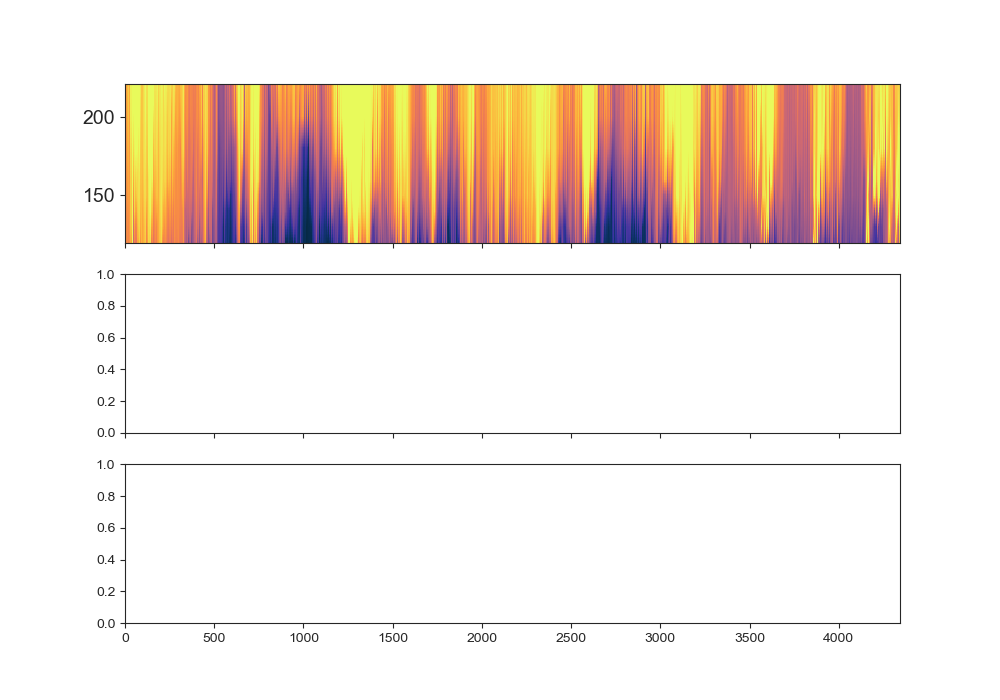

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 7),sharex=True)

x_labels = ['Jan','Feb','Mar','Apr','May','Jun']
linewidth = 1.5

a1 = ax[0]
a1.tick_params(labelsize=14)
pc = a1.pcolor(xi10,yi10,zT10, cmap=cmocean.cm.thermal, vmin=zlims[0], vmax=zlims[1])
a1.scatter(inevhr10,[ymax10-1]*inevhr10.shape[0],marker='^',color='w')
for inevhr in inevhr10:
    a1.axvline(inevhr,linestyle=(0,(5,10)),color='w')
a1.set_ylim([ymin10,ymax10][::-1])
a1.set_xlim([0,4343])
# a1.set_xlabel(maincol)
a1.set_xticks(np.arange(1,181.0*24,730.5))
# a1.set_xticklabels(x_labels)
a1.set_ylabel('Depth [m]',fontsize=14)
a1.text(50,ymin10+15,'2010',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5)) 

a11 = a1.twinx()
a11.tick_params(labelsize=14)
a11.plot(era5WindH['2010']['Hours'],era5WindH['2010']['ERA5WindVSW_filt'],color='k',linewidth=1)
# a11.plot(SSH_H['2010']['Hours'],SSH_H['2010']['SSH_filt'],color='k',linewidth=1)
a11.set_ylim([-8,18])
a11.set_yticks([-5,0,5,10,15])
a11.set_ylabel('Vel. [m/s]',rotation=270,fontsize=14,labelpad=10)
a11.set_xlim([0,4343])

a2 = ax[1]
a2.tick_params(labelsize=14)
pc = a2.pcolor(xi11,yi11,zT11, cmap=cmocean.cm.thermal, vmin=zlims[0], vmax=zlims[1])
a2.scatter(inevhr11,[ymax11-1]*inevhr11.shape[0],marker='^',color='w')
for inevhr in inevhr11:
    a2.axvline(inevhr,linestyle=(0,(5,10)),color='w')
a2.set_ylim([ymin11,ymax11][::-1])
a2.set_xlim([0,4343])
# a2.set_xlabel(maincol)
a2.set_xticks(np.arange(1,181.0*24,730.5))
# a2.set_xticklabels(x_labels)
a2.set_ylabel('Depth [m]',fontsize=14)
a2.text(50,ymin11+15,'2011',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))

a22 = a2.twinx()
a22.tick_params(labelsize=14)
a22.plot(era5WindH['2011']['Hours'],era5WindH['2011']['ERA5WindVSW_filt'],color='k',linewidth=1)
# a22.plot(SSH_H['2011']['Hours'],SSH_H['2011']['SSH_filt'],color='k',linewidth=1)
a22.set_ylim([-8,18])
a22.set_yticks([-5,0,5,10,15])
a22.set_ylabel('Vel. [m/s]',rotation=270,fontsize=14,labelpad=10)
a22.set_xlim([0,4343])

a3 = ax[2]
a3.tick_params(labelsize=14)
pc = a3.pcolor(xi12,yi12,zT12, cmap=cmocean.cm.thermal, vmin=zlims[0], vmax=zlims[1])
a3.scatter(inevhr12,[ymax12-1]*inevhr12.shape[0],marker='^',color='w')
for inevhr in inevhr12:
    a3.axvline(inevhr,linestyle=(0,(5,10)),color='w')
a3.set_ylim([ymin12,ymax12][::-1])
a3.set_xlim([0,4343])
# a3.set_xlabel(maincol)
a3.set_xticks(np.arange(1,181.0*24,730.5))
a3.set_xticklabels(x_labels)
a3.set_ylabel('Depth [m]',fontsize=14)
a3.text(50,ymin12+15,'2012',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))

a33 = a3.twinx()
a33.tick_params(labelsize=14)
a33.plot(era5WindH['2012']['Hours'],era5WindH['2012']['ERA5WindVSW_filt'],color='k',linewidth=1)
# a33.plot(SSH_H['2012']['Hours'],SSH_H['2012']['SSH_filt'],color='k',linewidth=1)
a33.set_ylim([-8,18])
a33.set_yticks([-5,0,5,10,15])
a33.set_ylabel('Vel. [m/s]',rotation=270,fontsize=14,labelpad=10)
a33.set_xlim([0,4343])

fig.subplots_adjust(bottom=0.05,top=0.95,left=0.08,right=0.8,hspace=0.05)
cbar_ax = fig.add_axes([0.88,0.05,0.03,0.9])
cbar = fig.colorbar(pc,cax=cbar_ax)
cbar.ax.tick_params(color='k',size=5,labelsize=14)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.set_ylabel('Temperature [C]', rotation=270,fontsize=14)

# plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/MODISWinds_Manuscript/Figures/WaterColumnTimeseries20201020.jpg', format='jpg', dpi=400)
plt.show()

In [15]:
# Intrusions dates from MODIS imagery
# Copied from MODISWindEvents sub_ev_storm2.MODIS_sighting.values
inev10 = pd.to_datetime(['1-24-2010 12:00:00','2-17-2010 12:00:00','3-5-2010 12:00:00','3-12-2010 12:00:00','3-15-2010 12:00:00','3-26-2010 12:00:00',
                       '3-31-2010 12:00:00','4-6-2010 12:00:00','4-11-2010 12:00:00','4-16-2010 12:00:00','4-30-2010 12:00:00','5-6-2010 12:00:00'])#12
inev11 = pd.to_datetime(['1-24-2011 12:00:00','2-17-2011 12:00:00','2-26-2011 12:00:00','3-3-2011 12:00:00',
                       '3-6-2011 12:00:00','3-26-2011 12:00:00','4-11-2011 12:00:00','4-14-2011 12:00:00',
                         '4-19-2011 12:00:00','5-7-2011 12:00:00','5-29-2011 12:00:00','6-1-2011 12:00:00','2011-06-15 12:00:00']) #13     
inev12 = pd.to_datetime(['1-19-2012 12:00:00','1-26-2012 12:00:00','1-29-2012 12:00:00',
                       '2-08-2012 12:00:00','2-16-2012 12:00:00','3-9-2012 12:00:00','3-14-2012 12:00:00','3-27-2012 12:00:00','4-3-2012 12:00:00',
                       '4-13-2012 12:00:00','4-28-2012 12:00:00','5-3-2012 12:00:00','5-26-2012 12:00:00',
                       '6-11-2012 12:00:00','6-19-2012 12:00:00','6-25-2012 12:00:00']) #17
inev13 = pd.to_datetime(['1-28-2013 12:00:00','2-4-2013 12:00:00','2-10-2013 12:00:00','3-01-2013 12:00:00','3-12-2013 12:00:00','3-22-2013 12:00:00',
                         '4-8-2013 12:00:00','4-24-2013 12:00:00','4-27-2013 12:00:00','5-9-2013 12:00:00','5-15-2013 12:00:00','5-20-2013 12:00:00',
                         '5-24-2013 12:00:00','5-28-2013 12:00:00','06-08-2013 12:00:00','6-16-2013 12:00:00','6-27-2013 12:00:00'])#17
starthr = pd.to_datetime('2010-01-01 00:00:00')
inevhr10 = (inev10-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2011-01-01 00:00:00')
inevhr11 = (inev11-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2012-01-01 00:00:00')
inevhr12 = (inev12-starthr).astype('timedelta64[h]')
starthr = pd.to_datetime('2013-01-01 00:00:00')
inevhr13 = (inev13-starthr).astype('timedelta64[h]')

In [16]:
inev10.shape[0]+inev11.shape[0]+inev12.shape[0]+inev13.shape[0]

58

In [ ]:
# # Actual intrusion start times
# inev10 = pd.to_datetime(['1-24-2010 00:00:00','2-13-2010 18:00:00','2-16-2010 12:00:00','3-3-2010 12:00:00','3-5-2010 00:00:00',
#                         '3-11-2010 18:00:00','3-15-2010 00:00:00','3-25-2010 18:00:00','3-30-2010 18:00:00',
#                         '4-06-2010 12:00:00','4-11-2010 12:00:00','4-16-2010 18:00:00' ,'4-22-2010 00:00:00',
#                         '4-30-2010 06:00:00','5-4-2010 06:00:00','5-5-2010 18:00:00','11-22-2010 18:00:00'])
# inev11 = pd.to_datetime(['1-24-2011 18:00:00','2-15-2011 12:00:00','2-25-2011 06:00:00','3-3-2011 00:00:00',
#                         '3-6-2011 00:00:00' ,'3-10-2011 12:00:00','3-14-2011 06:00:00','3-21-2011 18:00:00',
#                         '3-25-2011 18:00:00','4-11-2011 00:00:00','4-14-2011 06:00:00','4-19-2011 06:00:00',
#                         '5-8-2011 18:00:00','5-23-2011 06:00:00','6-01-2011 12:00:00'])
# inev12 = pd.to_datetime(['1-25-2012 12:00:00','1-29-2012 12:00:00',
#                         '2-8-2012 00:00:00','2-10-2012 06:00:00','2-15-2012 06:00:00',
#                         '3-7-2012 00:00:00','3-14-2012 00:00:00','3-21-2012 18:00:00',
#                         '3-27-2012 00:00:00','4-3-2012 00:00:00','4-5-2012 18:00:00','4-13-2012 00:00:00',
#                         '4-20-2012 06:00:00','4-27-2012 06:00:00','4-30-2012 12:00:00','5-2-2012 12:00:00',
#                         '5-25-2012 12:00:00','6-11-2012 06:00:00','6-15-2012 00:00:00',
#                         '6-18-2012 00:00:00','6-24-2012 18:00:00','6-30-2012 12:00:00',
#                         '7-3-2012 18:00:00','7-12-2012 00:00:00'])
# inev13 = pd.to_datetime(['1-28-2013 12:00:00','2-4-2013 12:00:00','3-1-2013 06:00:00','3-12-2013 00:00:00','3-22-2013 12:00:00',
#                         '4-8-2013 18:00:00','4-22-2013 12:00:00','4-23-2013 00:00:00','4-27-2013 00:00:00',
#                         '5-8-2013 00:00:00','5-20-2013 06:00:00','6-16-2013 00:00:00'])
# starthr = pd.to_datetime('2010-01-01 00:00:00')
# inevhr10 = (inev10-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2011-01-01 00:00:00')
# inevhr11 = (inev11-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2012-01-01 00:00:00')
# inevhr12 = (inev12-starthr).astype('timedelta64[h]')
# starthr = pd.to_datetime('2013-01-01 00:00:00')
# inevhr13 = (inev13-starthr).astype('timedelta64[h]')

In [17]:
era5WindH.head()

,ERA5WindSpd,ERA5WindU,ERA5WindV,ERA5PitSpd,ERA5PitU,ERA5PitV,ERA5BarSpd,ERA5BarU,ERA5BarV,ERA5WindDeg,ERA5WindDegSW,ERA5WindUSW,ERA5WindVSW,ERA5PitDeg,ERA5PitEvents,ERA5BarDeg,ERA5BarEvents,Hours
Datetime,,,,,,,,,,,,,,,,,,
1990-01-01 00:00:00,7.463045,-6.613215,-1.659940,12.647799,-10.624791,-6.861532,6.446016,-5.846509,0.982596,75.909653,193.909653,1.794053,7.244199,57.145466,False,99.540285,False,-175320.0
1990-01-01 06:00:00,7.505595,-5.169717,-5.360858,12.534474,-10.295523,-7.149492,4.664646,-2.616833,-1.243066,43.960135,161.960135,-2.324323,7.136630,55.222831,False,64.591028,False,-175314.0
1990-01-01 12:00:00,8.397875,0.546504,8.017101,13.758399,-12.998932,-4.507916,8.268983,0.996155,8.063526,183.899664,301.899664,7.129584,-4.437717,70.873902,False,187.042544,False,-175308.0
1990-01-01 18:00:00,7.977679,-3.493768,6.996935,4.535568,-4.461402,-0.816866,8.608839,-1.664467,8.140456,153.465746,271.465746,7.975069,-0.204064,79.624281,False,168.444103,False,-175302.0
1990-01-02 00:00:00,8.541435,-6.783481,5.057901,4.013691,-4.003197,-0.290049,8.732940,-5.323111,6.606824,126.708956,244.708956,7.722733,3.649042,85.855912,False,141.141642,False,-175296.0


In [18]:
piteraqs = era5WindH[['Hours','ERA5PitEvents']][era5WindH['ERA5PitEvents']==1]
barriers = era5WindH[['Hours','ERA5BarEvents']][era5WindH['ERA5BarEvents']==1]
barriers.head(2)

,Hours,ERA5BarEvents
Datetime,,
1990-01-21,-174840.0,True
1990-02-17,-174192.0,True


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
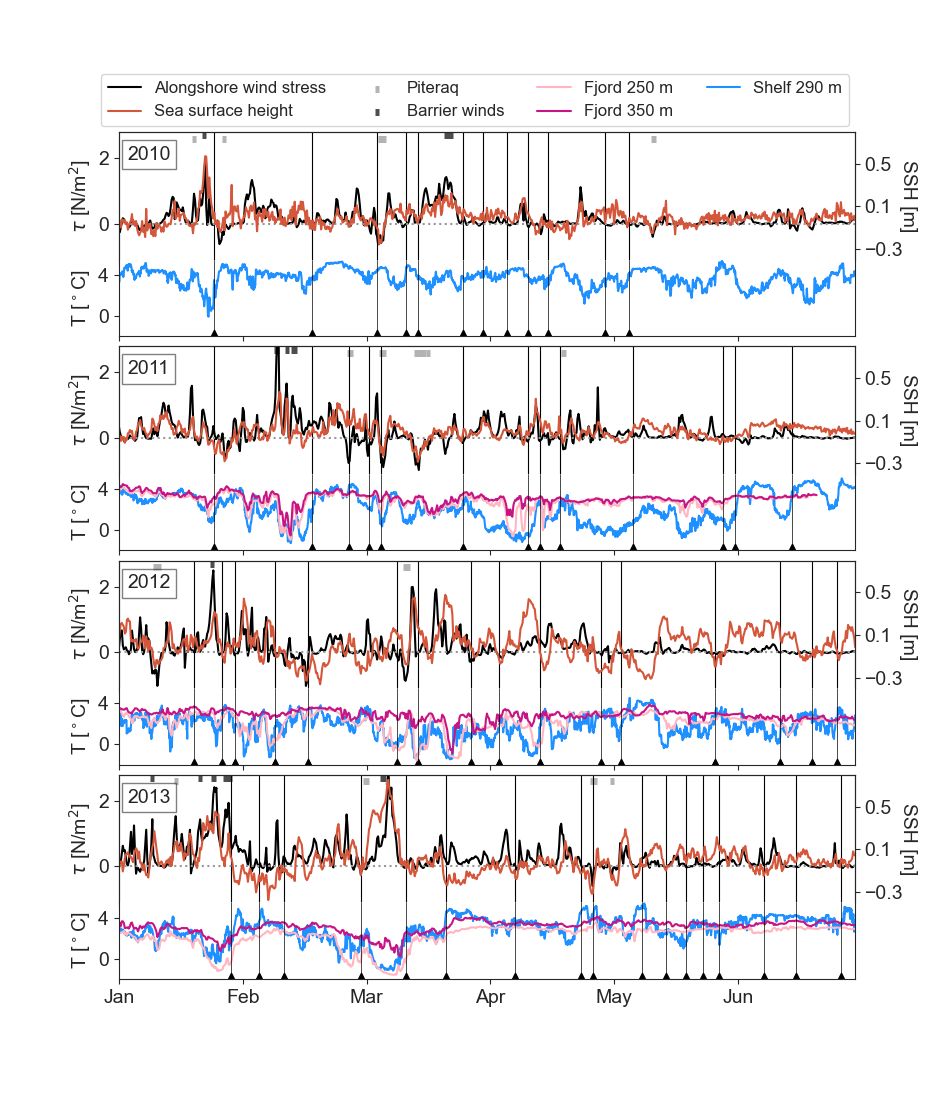

In [19]:
def make_plt1(cell,year,inev,leg1=False):
    '''This makes plots of wind stress and sea surface height'''
    ax = plt.subplot(cell)
    plt.gca().spines['bottom'].set_color('none')
    ax.tick_params(labelsize=14)
    w1, = ax.plot(era5StressH.loc[year]['Hours'],era5StressH.loc[year]['ERA5StressVSW'],color='k',linewidth=1.5,label='Alongshore wind stress')
    w2 = ax.scatter(piteraqs.loc[year]['Hours'],piteraqs.loc[year]['ERA5PitEvents']*2.6,color='0.7',marker='_',s=10,linewidths=5,label='Piteraq') 
    w3 = ax.scatter(barriers.loc[year]['Hours'],barriers.loc[year]['ERA5BarEvents']*2.7,color='0.3',marker='_',s=10,linewidths=5,label='Barrier Winds')
    for inevhr in inev:
        ax.axvline(inevhr,linestyle='-',linewidth=0.8,color='k')
    ax.axhline(0,linestyle=':',linewidth=1.5,color='0.6')
    # a1.set_ylim([-16,27]) # for wind speed VSW
    ax.set_ylim([-1.1,2.8])
    ax.set_yticks([0,2])
    ax.set_xlim([0,4343])
    ax.set_xticks(np.arange(1,181.0*24,730.5))
    ax.set_xticklabels([])
    ax.set_ylabel('$\\tau$ [N/m$^2$]',fontsize=14)
    ax.text(50,1.95,year,fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))    

    a1 = ax.twinx()
    a1.tick_params(labelsize=14)
    plt.gca().spines['bottom'].set_color('none')
    w4, = a1.plot(SSH_H.loc[year]['Hours'],SSH_H.loc[year]['SSH'],color='#D5573B',linewidth=1.5,label='Sea surface height') #D5573B #519E8A
    a1.set_ylim([-0.4,0.8])
    a1.set_yticks([-0.3,0.1,0.5])
    a1.set_ylabel('SSH [m]',rotation=270,fontsize=14,labelpad=10)
    a1.set_xlim([0,4343])
    a1.set_xticklabels([])
    
    return w1,w2,w3,w4

def make_plt2(cell,year,inev,leg1=False,xlabel=False):
    '''This makes timeseries' of ocean temperature'''
    ax = plt.subplot(cell)
    ax.tick_params(labelsize=14)
    plt.gca().spines['top'].set_color('none')
    o1, = ax.plot(all_shelf290.loc[f'{year}-01':f'{year}-07']['Hours'],all_shelf290.loc[f'{year}-01':f'{year}-07']['Temperature [C]'],color='dodgerblue',linewidth=1.5,label='Shelf 290 m') 
    o2, = ax.plot(allmidmoorH.loc[year]['Hours'],allmidmoorH.loc[year]['Tempmid250m'],color='lightpink',linewidth=1.5,label='Fjord 250 m')
    o3, = ax.plot(allmidmoorH.loc[year]['Hours'],allmidmoorH.loc[year]['Tempmid350m'],color='mediumvioletred',linewidth=1.5,label='Fjord 350 m')
    ax.scatter(inev,[-1.8]*inev.shape[0],marker='^',color='k')
    for inevhr in inev:
        ax.axvline(inevhr,linestyle='-',linewidth=0.5,color='k')
    # a1.set_ylim([-1.1,2.8])
    # a1.set_yticks([-1,0,1,2])
    ax.set_xticks(np.arange(1,181.0*24,730.5))
    ax.set_xlim([0,4343])
    ax.set_ylim([-2.0,5.5])
    ax.set_yticks([0,4])
    ax.set_ylabel('T [$^\circ$C]',fontsize=14)
    # a1.text(40,2.1,'2010',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))
    if xlabel==True:
        ax.set_xticklabels(x_labels)
    else:
        ax.set_xticklabels([])
    
    return o1,o2,o3

##########################################
# def make_plt1(cell,year,inev,leg1=False,leg2=False):
#     '''This makes plots of wind stress and sea surface height with legends in middle of plot'''
#     ax = plt.subplot(cell)
#     plt.gca().spines['bottom'].set_color('none')
#     ax.tick_params(labelsize=14)
#     ax.plot(era5StressH[year]['Hours'],era5StressH[year]['ERA5StressVSW'],color='k',linewidth=1.5,label='Alongshore wind stress')
# #     ax.scatter(inev,[-1.0]*inev.shape[0],marker='^',color='k')
#     ax.scatter(piteraqs[year]['Hours'],piteraqs[year]['ERA5PitEvents']*2.6,color='0.7',marker='_',s=10,linewidths=3,label='Piteraq') #label='_no legend_') label='Piteraq')
#     ax.scatter(barriers[year]['Hours'],barriers[year]['ERA5BarEvents']*2.7,color='0.3',marker='_',s=10,linewidths=3,label='Barrier Winds') #label='_no legend_') label='Barrier Winds')
#     for inevhr in inev:
#         ax.axvline(inevhr,linestyle='-',linewidth=0.8,color='k')
#     ax.axhline(0,linestyle=':',linewidth=1.5,color='0.6')
#     # a1.set_ylim([-16,27]) # for wind speed VSW
#     ax.set_ylim([-1.1,2.8])
#     ax.set_yticks([0,2])
#     ax.set_xlim([0,4343])
#     ax.set_xticks(np.arange(1,181.0*24,730.5))
#     ax.set_xticklabels([])
#     ax.set_ylabel('$\\tau$ [N/m$^2$]',fontsize=14)
#     ax.text(40,2.25,year,fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5)) 
#     if leg1==True:
#         ax.legend(loc='upper right',markerscale=1,fontsize=14)

#     a1 = ax.twinx()
#     a1.tick_params(labelsize=14)
#     plt.gca().spines['bottom'].set_color('none')
#     a1.plot(SSH_H[year]['Hours'],SSH_H[year]['SSH'],color='#D5573B',linewidth=1.5,label='Sea surface height') #D5573B #519E8A
#     a1.set_ylim([-0.4,0.8])
#     a1.set_yticks([-0.3,0.1,0.5])
#     a1.set_ylabel('SSH [m]',rotation=270,fontsize=14,labelpad=10)
#     a1.set_xlim([0,4343])
#     a1.set_xticklabels([])
#     if leg2==True:
#         a1.legend(loc='upper right',markerscale=1,fontsize=14)

# def make_plt2(cell,year,inev,leg1=False,xlabel=False):
#     '''This makes timeseries' of ocean temperature'''
#     ax = plt.subplot(cell)
#     ax.tick_params(labelsize=14)
#     plt.gca().spines['top'].set_color('none')
#     ax.plot(all_shelf290[year]['Hours'],all_shelf290[year]['Temperature [C]'],color='dodgerblue',linewidth=1.5,label='Shelf 290 m') 
#     ax.plot(allmidmoorH[year]['Hours'],allmidmoorH[year]['Tempmid250m'],color='lightpink',linewidth=1.5,label='Fjord 250 m')
#     ax.plot(allmidmoorH[year]['Hours'],allmidmoorH[year]['Tempmid350m'],color='mediumvioletred',linewidth=1.5,label='Fjord 350 m')
#     ax.scatter(inev,[-1.8]*inev.shape[0],marker='^',color='k')
#     for inevhr in inev:
#         ax.axvline(inevhr,linestyle='-',linewidth=0.5,color='k')
#     # a1.set_ylim([-1.1,2.8])
#     # a1.set_yticks([-1,0,1,2])
#     ax.set_xticks(np.arange(1,181.0*24,730.5))
#     ax.set_xlim([0,4343])
#     ax.set_ylim([-2.0,5.5])
#     ax.set_yticks([0,4])
#     ax.set_ylabel('T [$^\circ$C]',fontsize=14)
#     # a1.text(40,2.1,'2010',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))
#     if xlabel==True:
#         ax.set_xticklabels(x_labels)
#     else:
#         ax.set_xticklabels([])
#     if leg1==True:
#         ax.legend(loc='lower right',markerscale=1,fontsize=14)
        
# def make_plt2(cell,year,inev,xi,yi,zT,leg1=False,leg2=False,xlabel=False,nomesh=False):
#     "This makes heatmaps with x,y,z grids"
#     ax = plt.subplot(cell)
#     ax.tick_params(labelsize=14)
#     plt.gca().spines['top'].set_color('none')
#     if nomesh==False:
#         pc = ax.pcolormesh(xi,yi,zT, cmap=cmocean.cm.thermal, vmin=-2, vmax=4.5)
#         ax.set_xticks(np.arange(1,181.0*24,730.5))
#         ax.set_xlim([0,4343])
#         ax.set_ylim([yi.min(),yi.max()][::-1])
#     #     ax.set_yticks([100,200,300])
#         ax.set_ylabel('Depth [m]',fontsize=14)
#         if xlabel==True:
#             ax.set_xticklabels(x_labels)
#         else:
#             ax.set_xticklabels([])
#         if leg1==True:
#             cbar_ax = fig.add_axes([0.88,0.05,0.03,0.9])
#             cbar = fig.colorbar(pc,cax=cbar_ax)
#             cbar.ax.tick_params(color='k',size=5,labelsize=14)
#             cbar.ax.get_yaxis().labelpad = 8
#             cbar.ax.set_ylabel('Temperature [C]', rotation=270,fontsize=14)
    
#     a1 = ax.twinx()
#     a1.tick_params(labelsize=14)
#     plt.gca().spines['top'].set_color('none')
#     a1.plot(all_shelfmoorH[year]['Hours'],all_shelfmoorH[year]['Tempshelf290m'],color='k',linewidth=1.5,label='Shelf 290 m')
#     a1.plot(allmidmoorH[year]['Hours'],allmidmoorH[year]['Tempmid250m'],color='0.8',linewidth=1.5,label='Fjord 250 m')
#     a1.plot(allmidmoorH[year]['Hours'],allmidmoorH[year]['Tempmid350m'],color='0.5',linewidth=1.5,label='Fjord 350 m')
#     a1.scatter(inev,[-1.8]*inev.shape[0],marker='^',color='k')
#     for inevhr in inev:
#         a1.axvline(inevhr,linestyle='-',linewidth=0.8,color='k')
#     a1.set_xlim([0,4343])
#     a1.set_ylim([-2.0,5.5])
#     a1.set_yticks([0,4])
#     a1.set_ylabel('T [$^\circ$C]',fontsize=14,rotation=270,labelpad=20)
#     a1.set_xticklabels([])
#     if leg2==True:
#         a1.legend(loc='lower right',markerscale=1,fontsize=14,framealpha=1)
#         a1.text(5,-1.8,'Shelf vertical temperature profiles',color='k',fontsize=14)
    

x_labels = ['Jan','Feb','Mar','Apr','May','Jun']
linewidth = 1.5

fig, am = plt.subplots(nrows=8, ncols=1, figsize=(9.5, 11),sharex=True)
plt.subplots_adjust(hspace=0.05)
outer = gridspec.GridSpec(4,1)
gs1 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[0],hspace=0.00)

# Plot of wind stress, SSH, and mooring timeseries with events marked
gs2 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[1],hspace=0.0)
gs3 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[2],hspace=0.0)
gs4 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[3],hspace=0.0)

w1,w2,w3,w4 = make_plt1(gs1[0],'2010',inevhr10,leg1=True)
o1,o2,o3 = make_plt2(gs1[1],'2010',inevhr10,leg1=True)
w1,w2,w3,w4 = make_plt1(gs2[0],'2011',inevhr11) #,leg2=True)
o1,o2,o3 = make_plt2(gs2[1],'2011',inevhr11)
w1,w2,w3,w4 = make_plt1(gs3[0],'2012',inevhr12)
o1,o2,o3 = make_plt2(gs3[1],'2012',inevhr12)
w1,w2,w3,w4 = make_plt1(gs4[0],'2013',inevhr13)
o1,o2,o3 = make_plt2(gs4[1],'2013',inevhr13,xlabel=True)

# handles, labels = fig.gca.get_legend_handles_labels()
fig.legend([w1,w4,w2,w3,o2,o3,o1],['Alongshore wind stress','Sea surface height','Piteraq','Barrier winds','Fjord 250 m','Fjord 350 m','Shelf 290 m'],
           loc='upper center', bbox_to_anchor=(0.5,0.94),markerscale=1,fontsize=12, ncol=4)

# # Plot of wind stress, SSH, and mooring water column heatmap with events marked
# gs1 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[0],hspace=0.0)
# gs2 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[1],hspace=0.0)
# gs3 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[2],hspace=0.0)
# gs4 = gridspec.GridSpecFromSubplotSpec(2,1,height_ratios=(1.25,0.75),subplot_spec=outer[3],hspace=0.0)

# make_plt1(gs1[0],'2010',inevhr10,leg1=True)
# make_plt2(gs1[1],'2010',inevhr10,xi10,yi10,zT10,leg1=True,leg2=True,)
# make_plt1(gs2[0],'2011',inevhr11,leg2=True)
# make_plt2(gs2[1],'2011',inevhr11,xi11,yi11,zT11)
# make_plt1(gs3[0],'2012',inevhr12)
# make_plt2(gs3[1],'2012',inevhr12,xi12,yi12,zT12)
# make_plt1(gs4[0],'2013',inevhr13)
# make_plt2(gs4[1],'2013',inevhr13,None,None,None,xlabel=True,nomesh=True)

# plt.tight_layout(h_pad=0.05)
plt.savefig(var_dir + 'MODISWinds_Manuscript/Figures/WindSSHMoorTimeseries20221230.jpg', format='jpg', dpi=400)
plt.show()

/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/827747379.py:9: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  a1.plot(era5StressH['2010']['Hours'],era5StressH['2010']['ERA5StressVSW'],color='mediumvioletred',linewidth=1.5,label='Alongshore wind stress')
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/827747379.py:26: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  a11.plot(SSH_H['2010']['Hours'],SSH_H['2010']['SSH'],color='k',linewidth=1.5)
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_99083/827747379.py:34: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
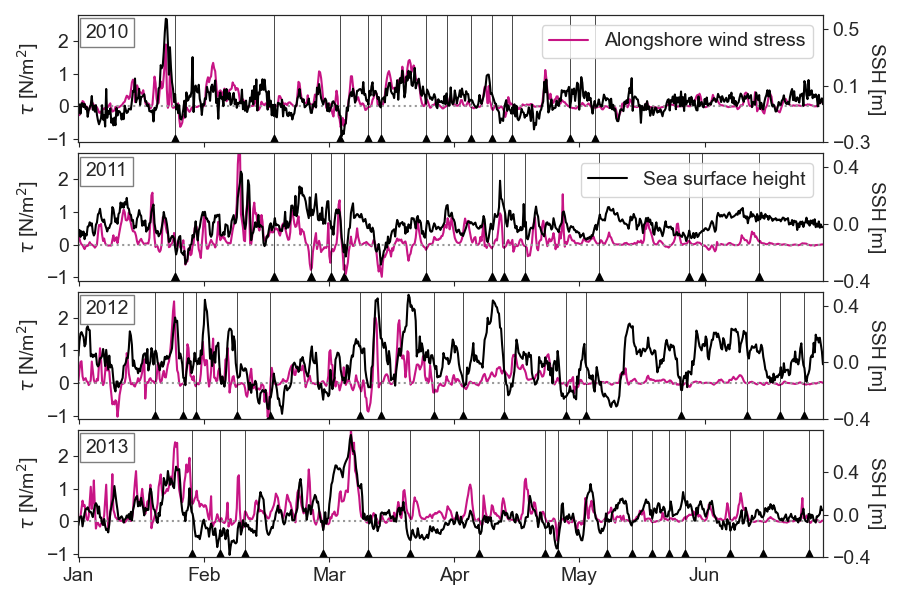

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9, 6),sharex=True)

x_labels = ['Jan','Feb','Mar','Apr','May','Jun']
linewidth = 1.5

a1 = ax[0]
a1.tick_params(labelsize=14)
# a1.plot(era5WindH['2010']['Hours'],era5WindH['2010']['ERA5WindVSW'],color='mediumvioletred',linewidth=1.5,label='Alongshore winds')
a1.plot(era5StressH['2010']['Hours'],era5StressH['2010']['ERA5StressVSW'],color='mediumvioletred',linewidth=1.5,label='Alongshore wind stress')
a1.scatter(inevhr10,[-1.0]*inevhr10.shape[0],marker='^',color='k')
for inevhr in inevhr10:
    a1.axvline(inevhr,linestyle='-',linewidth=0.5,color='k')
a1.axhline(0,linestyle=':',linewidth=1.5,color='0.6')
# a1.set_ylim([-16,27]) # for wind speed VSW
a1.set_ylim([-1.1,2.8])
a1.set_yticks([-1,0,1,2])
a1.set_xlim([0,4343])
a1.set_xticks(np.arange(1,181.0*24,730.5))
a1.set_ylabel('$\\tau$ [N/m$^2$]',fontsize=14)
a1.text(40,2.1,'2010',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5)) 
a1.legend(loc='upper right',markerscale=1,fontsize=14)
# a1.spines('bottom').set_visible(False)

a11 = a1.twinx()
a11.tick_params(labelsize=14)
a11.plot(SSH_H['2010']['Hours'],SSH_H['2010']['SSH'],color='k',linewidth=1.5)
a11.set_ylim([-0.3,0.6])
a11.set_yticks([-0.3,0.1,0.5])
a11.set_ylabel('SSH [m]',rotation=270,fontsize=14,labelpad=10)
a11.set_xlim([0,4343])

a2 = ax[1]
a2.tick_params(labelsize=14)
a2.plot(era5StressH['2011']['Hours'],era5StressH['2011']['ERA5StressVSW'],color='mediumvioletred',linewidth=1.5)
a2.scatter(inevhr11,[-1.0]*inevhr11.shape[0],marker='^',color='k')
for inevhr in inevhr11:
    a2.axvline(inevhr,linestyle='-',linewidth=0.5,color='k')
a2.axhline(0,linestyle=':',linewidth=1.5,color='0.6')
a2.set_ylim([-1.1,2.8])
a2.set_yticks([-1,0,1,2])
a2.set_xlim([0,4343])
a2.set_xticks(np.arange(1,181.0*24,730.5))
a2.set_ylabel('$\\tau$ [N/m$^2$]',fontsize=14)
a2.text(40,2.1,'2011',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))

a22 = a2.twinx()
a22.tick_params(labelsize=14)
a22.plot(SSH_H['2011']['Hours'],SSH_H['2011']['SSH'],color='k',linewidth=1.5,label='Sea surface height')
a22.set_ylim([-0.4,0.5])
a22.set_yticks([-0.4,0,0.4])
a22.set_ylabel('SSH [m]',rotation=270,fontsize=14,labelpad=10)
a22.set_xlim([0,4343])
a22.legend(loc='upper right',markerscale=2,fontsize=14)

a3 = ax[2]
a3.tick_params(labelsize=14)
a3.plot(era5StressH['2012']['Hours'],era5StressH['2012']['ERA5StressVSW'],color='mediumvioletred',linewidth=1.5)
a3.scatter(inevhr12,[-1.0]*inevhr12.shape[0],marker='^',color='k')
for inevhr in inevhr12:
    a3.axvline(inevhr,linestyle='-',linewidth=0.5,color='k')
a3.axhline(0,linestyle=':',linewidth=1.5,color='0.6')
a3.set_ylim([-1.1,2.8])
a3.set_yticks([-1,0,1,2])
a3.set_xlim([0,4343])
a3.set_xticks(np.arange(1,181.0*24,730.5))
a3.set_ylabel('$\\tau$ [N/m$^2$]',fontsize=14)
a3.text(40,2.1,'2012',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))

a33 = a3.twinx()
a33.tick_params(labelsize=14)
a33.plot(SSH_H['2012']['Hours'],SSH_H['2012']['SSH'],color='k',linewidth=1.5)
a33.set_ylim([-0.4,0.5])
a33.set_yticks([-0.4,0,0.4])
a33.set_ylabel('SSH [m]',rotation=270,fontsize=14,labelpad=10)
a33.set_xlim([0,4343])

a4 = ax[3]
a4.tick_params(labelsize=14)
a4.plot(era5StressH['2013']['Hours'],era5StressH['2013']['ERA5StressVSW'],color='mediumvioletred',linewidth=1.5)
a4.scatter(inevhr13,[-1.0]*inevhr13.shape[0],marker='^',color='k')
for inevhr in inevhr13: 
    a4.axvline(inevhr,linestyle='-',linewidth=0.5,color='k')
a4.axhline(0,linestyle=':',linewidth=1.5,color='0.6')
a4.set_ylim([-1.1,2.8])
a4.set_yticks([-1,0,1,2])
a4.set_xlim([0,4343])
a4.set_xticks(np.arange(1,181.0*24,730.5))
a4.set_xticklabels(x_labels)
a4.set_ylabel('$\\tau$ [N/m$^2$]',fontsize=14)
a4.text(40,2.1,'2013',fontsize=14,bbox=dict(facecolor='white',ec='k',alpha=0.5))

a44 = a4.twinx()
a44.tick_params(labelsize=14)
a44.plot(SSH_H['2013']['Hours'],SSH_H['2013']['SSH'],color='k',linewidth=1.5)
a44.set_ylim([-0.4,0.8])
a44.set_yticks([-0.4,0,0.4])
a44.set_ylabel('SSH [m]',rotation=270,fontsize=14,labelpad=10)
a44.set_xlim([0,4343])

plt.tight_layout(h_pad=0.0)
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/MODISWinds_Manuscript/Figures/WindSSHTimeseries20201020.jpg', format='jpg', dpi=400)
plt.show()

In [21]:
# Smooth climatology for SSTadj and intrusion
SSH6 = SSH_H.resample('6H').mean()
midmoor = allmidmoorH['2010-08-24 12:00:00':'2013-08-19 12:00:00'][['Tempmid250m','Tempmid350m','Tempmid400m']]
# midmoor = midmoor.interpolate(method='spline', order=2, s=0.)
wssh = pd.concat([SSH_H['2009-08-24 18:00:00':'2013-08-18 12:00:00']['SSH'],era5WindH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['ERA5WindVSW'],all_shelfmoorH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['Tempshelf290m'],allmidmoorH['2010-08-24 12:00:00':'2013-08-19 12:00:00'],era5StressH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['ERA5StressVSW']],axis=1)
wssh = wssh.interpolate(method='spline', order=2, s=0.)

# freq=0.2
# # freq=0.025
# data1 = np.array(SSH6['SSH'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# SSH6['SSH_filt']= butterworth(data1,freq)[50:-50]

# data1 = np.array(wssh['SSH'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# wssh['SSH_filt']= butterworth(data1,freq)[50:-50]

# data1 = np.array(wssh['Tempshelf290m'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# wssh['Tempshelf290m_filt']= butterworth(data1,freq)[50:-50]

# data1 = np.array(era5WindH['ERA5WindVSW'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# era5WindH['ERA5WindVSW_filt'] = butterworth(data1,freq)[50:-50]

# data1 = np.array(wssh['ERA5WindVSW'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# wssh['ERA5WindVSW_filt']= butterworth(data1,freq)[50:-50]

# data1 = np.array(era5StressH['ERA5StressVSW'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# era5StressH['ERA5StressVSW_filt'] = butterworth(data1,freq)[50:-50]

# data1 = np.array(wssh['ERA5StressVSW'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# wssh['ERA5StressVSW_filt']= butterworth(data1,freq)[50:-50]
# # wssh['ERA5StressVSW_filt'] = era5StressH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['ERA5StressVSW_filt']

# data1 = np.array(midmoor['Tempmid250m'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# midmoor['Tempmid250m_filt']= butterworth(data1,freq)[50:-50]

# data1 = np.array(midmoor['Tempmid350m'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# midmoor['Tempmid350m_filt']= butterworth(data1,freq)[50:-50]

# data1 = np.array(midmoor['Tempmid400m'])
# data1 = np.concatenate([data1[-50:],data1,data1[:50]])
# midmoor['Tempmid400m_filt']= butterworth(data1,freq)[50:-50]

NameError: name 'all_shelfmoorH' is not defined

In [22]:
# +h means y leads x

data1 = 'Tempmid250m'
data2 = 'SSH'
# data1 = 'Tempmid250m_filt'
# data2 = 'SSH_filt'

wsshd = wssh[[data1,data2]]
# wsshd = (wssh[[data1,data2]].interpolate(method='spline', order=2, s=0.)).dropna()
wsshd = (pd.concat([wssh[data2],midmoor[data1]],axis=1).interpolate(method='spline', order=2, s=0.)).dropna()

# Calculate and remove seasonal variability and smooth with a 40d Butterworth, and linear trend
freq = 0.0025 # 100 day (400 time steps)
result1 = seasonal_decompose(wsshd[data1],model='additive',freq=1460)
wsshd[data1+'_seas'] = result1.seasonal.values
datab = np.array(wsshd[data1+'_seas'])
datab = np.concatenate([datab[-400:],datab,datab[:400]])
wsshd[data1+'_seasfilt'] = butterworth(datab,freq)[400:-400]
wsshd[data1+'_tr'] = result1.trend.values

result2 = seasonal_decompose(wsshd[data2],model='additive',freq=1460)
wsshd[data2+'_seas'] = result2.seasonal.values
datab = np.array(wsshd[data2+'_seas'])
datab = np.concatenate([datab[-400:],datab,datab[:400]])
wsshd[data2+'_seasfilt'] = butterworth(datab,freq)[400:-400]
wsshd[data2+'_tr'] = result2.trend.values

wsshd = wsshd.dropna()

datab = np.array(wsshd[data1+'_tr'])
datab = np.concatenate([datab[-400:],datab,datab[:400]])
wsshd[data1+'_trfilt'] = butterworth(datab,freq)[400:-400]
# XW = [i/1460.0 for i in range(0, len(wsshd[data1]))]
# XW = np.reshape(XW, (len(XW), 1))
# model = LinearRegression()
# model.fit(XW, wsshd[data1])
# wsshd[data1+'_tr'] = model.predict(XW)
wsshd[data1+'_dt'] = wsshd[data1] - wsshd[data1+'_trfilt'] - wsshd[data1+'_seasfilt']
wsshd[data1+'_norm'] = (wsshd[data1+'_dt'] - wsshd[data1+'_dt'].mean())/wsshd[data1+'_dt'].std()

datab = np.array(wsshd[data2+'_tr'])
datab = np.concatenate([datab[-400:],datab,datab[:400]])
wsshd[data2+'_trfilt'] = butterworth(datab,freq)[400:-400]
# XW = [i/1460.0 for i in range(0, len(wsshd[data2]))]
# XW = np.reshape(XW, (len(XW), 1))
# model = LinearRegression()
# model.fit(XW, wsshd[data2])
# wsshd[data2+'_tr'] = model.predict(XW)
wsshd[data2+'_dt'] = wsshd[data2] - wsshd[data2+'_trfilt'] - wsshd[data2+'_seasfilt']
wsshd[data2+'_norm'] = wsshd[data2+'_dt'] - wsshd[data2+'_dt'].mean()/wsshd[data2+'_dt'].std()

lag, ac = autocorr(wsshd[data1+'_dt'], wsshd[data1+'_dt'], twosided=False, tapered=True)

fig, ax = plt.subplots(figsize=(10, 5))

plt.tick_params(labelsize=14)
ax.set_facecolor('white')
plt.grid(color='.9')
plt.plot(lag*6, ac, c='C4',linewidth=1,label='SSH correlations')
plt.xlim([0,(40*4)*6])
plt.xlabel('Lag (hours)')
plt.ylabel('correlation')
plt.legend()
plt.show()

NameError: name 'wssh' is not defined

# Figure S4 - timeseries correlations and significance

In [20]:
def corr_prep(wsshd,data1,data2,freq=0.0025):
    # Calculate and remove seasonal variability and trend and smooth with a 100d Butterworth filter, normalize between 1,0
    result1 = seasonal_decompose(wsshd[data1],model='additive',period=1460)
    wsshd[data1+'_seas'] = result1.seasonal.values
    datab = np.array(wsshd[data1+'_seas'])
    datab = np.concatenate([datab[-400:],datab,datab[:400]])
    wsshd[data1+'_seasfilt'] = butterworth(datab,freq)[400:-400]
    wsshd[data1+'_tr'] = result1.trend.values

    result2 = seasonal_decompose(wsshd[data2],model='additive',period=1460)
    wsshd[data2+'_seas'] = result2.seasonal.values
    datab = np.array(wsshd[data2+'_seas'])
    datab = np.concatenate([datab[-400:],datab,datab[:400]])
    wsshd[data2+'_seasfilt'] = butterworth(datab,freq)[400:-400]
    wsshd[data2+'_tr'] = result2.trend.values

    wsshd = wsshd.dropna()

    datab = np.array(wsshd[data1+'_tr'])
    datab = np.concatenate([datab[-400:],datab,datab[:400]])
    wsshd[data1+'_trfilt'] = butterworth(datab,freq)[400:-400]
    wsshd[data1+'_dt'] = wsshd[data1] - wsshd[data1+'_trfilt'] - wsshd[data1+'_seasfilt']
    wsshd[data1+'_norm'] = (wsshd[data1+'_dt'] - wsshd[data1+'_dt'].mean())/wsshd[data1+'_dt'].std()

    datab = np.array(wsshd[data2+'_tr'])
    datab = np.concatenate([datab[-400:],datab,datab[:400]])
    wsshd[data2+'_trfilt'] = butterworth(datab,freq)[400:-400]
    wsshd[data2+'_dt'] = wsshd[data2] - wsshd[data2+'_trfilt'] - wsshd[data2+'_seasfilt']
    wsshd[data2+'_norm'] = wsshd[data2+'_dt'] - wsshd[data2+'_dt'].mean()/wsshd[data2+'_dt'].std()

    return wsshd[[data1+'_norm',data2+'_norm']]

from geographiclib.geodesic import Geodesic

def distcalc(pair1,pair2):
    '''
    Find distance in km 
    '''
    
    lat1,lon1 = pair1
    lat2,lon2 = pair2
    brng = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)

    return brng['s12']/1000  #distance in m/1000

In [ ]:
fig = tsaplots.plot_acf(pU, lags=100,alpha=0.05)
plt.plot(Te,val_Te,'bo')
plt.axhline(val_Te,color='b',label='Te')
plt.legend(loc=0)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title(f'Autocorrelation pU, dof = {dof}',fontsize=14)
plt.savefig(f'Autocorr_pU.png',bbox_inches='tight')
plt.close('all')

Text(0, 0.5, 'Correlation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
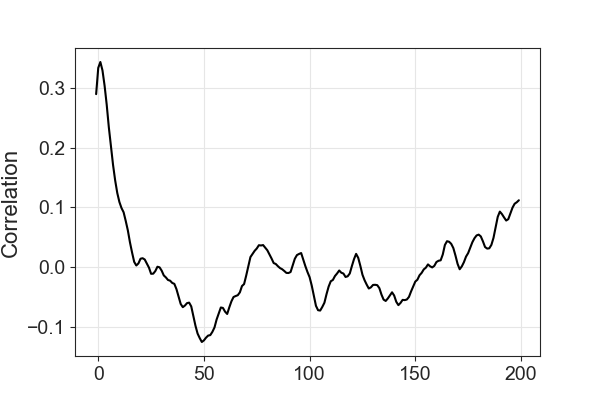

In [72]:
fig, ax = plt.subplots(figsize=(6, 4))
# sig1 = 2/(np.sqrt(forcor[data1].shape[0]-lag[minl]))

plt.tick_params(labelsize=14)
# plt.set_facecolor('white')
plt.grid(color='.9')
plt.plot(lagws, acws, c='k',linestyle='-',linewidth=1.5,label='SSH to wind stress')
plt.ylabel('Correlation',fontsize=16)

/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_18790/416088757.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 4))


Text(0, 0.5, 'Correlation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
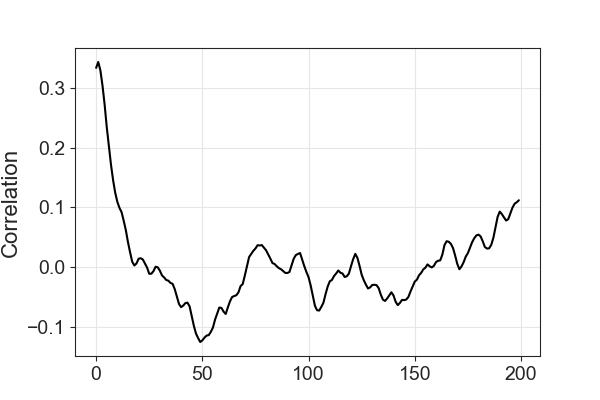

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))
# sig1 = 2/(np.sqrt(forcor[data1].shape[0]-lag[minl]))

plt.tick_params(labelsize=14)
# plt.set_facecolor('white')
plt.grid(color='.9')
plt.plot(lagws, acws, c='k',linestyle='-',linewidth=1.5,label='SSH to wind stress')
plt.ylabel('Correlation',fontsize=16)
# plt.legend(fontsize=14,markerscale=2)
# plt.text(-18,1.1,'a',weight='bold',fontsize=18)

In [ ]:
fig, ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(6, 8))
# sig1 = 2/(np.sqrt(forcor[data1].shape[0]-lag[minl]))

a1 = ax[0]
a1.tick_params(labelsize=14)
a1.set_facecolor('white')
a1.grid(color='.9')
a1.plot(lagws, acws, c='k',linestyle=':',linewidth=2,label='SSH to wind stress')
a1.set_ylabel('Norm. correlation',fontsize=16)
a1.legend(fontsize=14,markerscale=2)
a1.text(-18,1.1,'a',weight='bold',fontsize=18)

a2 = ax[1]
a2.tick_params(labelsize=14)
a2.set_facecolor('white')
a2.grid(color='.9')
a2.plot(lagwstsh, -acwstsh, c='k',linewidth=2,label='Shelf 290 m')
a2.plot(lagwstm2, -acwstm2, c='0.5',linewidth=2,label='Mid-fjord 250 m')
a2.plot(lagwstm3, -acwstm3, c='0.8',linewidth=2,label='Mid-fjord 400 m')
a2.text(2,1.1,'Correlation to wind stress',fontsize=16)
a2.set_ylabel('Norm. correlation',fontsize=16)
# a2.legend(fontsize=12,markerscale=2)
a2.text(-18,1.4,'b',weight='bold',fontsize=18)

a3 = ax[2]
a3.tick_params(labelsize=14)
a3.set_facecolor('white')
a3.grid(color='.9')
a3.plot(lagssh, -acssh, c='k',linewidth=2,label='Shelf 290 m')
a3.plot(lagsm2, -acsm2, c='0.5',linewidth=2,label='Mid-fjord 250 m')
a3.plot(lagsm3, -acsm3, c='0.8',linewidth=2,label='Mid-fjord 350 m')
a3.set_xlim([0,(40*4)])
a3.set_xticks(np.arange(0,(40*4),5.0*4))
a3.set_xticklabels(np.arange(0,40,5))
a3.set_xlabel('Lag (days)',fontsize=16)
a3.set_ylabel('Norm. correlation',fontsize=16)
a3.text(2,0.3,'Correlation to SSH',fontsize=16)
a3.legend(fontsize=14,markerscale=2)
a3.text(-18,0.6,'c',weight='bold',fontsize=18)

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/MODISWinds_Manuscript/Figures/CorrelWFiltNoSeasTr.jpg', format='jpg', dpi=400)
plt.show()

In [74]:
# Smooth climatology if needed and calculate correlations and edof
# EDOF significance calculated from (Sciremammano 1979)
SSH6 = SSH_H.resample('6H').mean()
midmoor = allmidmoorH['2010-08-24 12:00:00':'2013-08-19 12:00:00'][['Tempmid250m','Tempmid350m','Tempmid400m']]
# midmoor = midmoor.interpolate(method='spline', order=2, s=0.)
wssh = pd.concat([SSH_H['2009-08-24 18:00:00':'2013-08-18 12:00:00']['SSH'],era5WindH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['ERA5WindVSW'],all_shelfmoorH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['Tempshelf290m'],allmidmoorH['2010-08-24 12:00:00':'2013-08-19 12:00:00'],era5StressH['2009-08-24 18:00:00':'2013-08-18 12:00:00']['ERA5StressVSW']],axis=1)
# wssh_i = wssh.interpolate(method='spline', order=2, s=0.)

freq1 = 0.0025 # 100 day (400 time steps)
# filtx = '_filt'
filtx = ''
# corrx = ''
corrx = '_norm' # if doing corr_prep to remove trend and seas variability
lag = 200
method = 'min' # for edof calculation 'min' gives most conservative,then max, pathag, and model gives least conservative

data1 = 'SSH'+filtx
data2 = 'ERA5WindVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() #(wssh[[data1,data2]].interpolate(method='spline', order=2, s=0.)).dropna()
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagws, acws, pws = autocorr(wsshd,lag=lag,twosided=False)
# min1 = lagws[acws.argmin()]
# rws,pws = stats.pearsonr(stats.zscore(wsshd[data1][min1:]),stats.zscore(wsshd[data2].shift(min1)[min1:]))
# max1 = lagws[acws.argmax()]
# rws2,pws2 = stats.pearsonr(stats.zscore(wsshd[data1][max1:]),stats.zscore(wsshd[data2].shift(max1)[max1:]))
# sigws = 2/np.sqrt(wsshd.shape[0]-1)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99ws = 2.6*sig
C95ws = 2.0*sig

data1 = 'SSH'+filtx
data2 = 'ERA5StressVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq=0.0025)
lagwst, acwst, pwst = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wst = 2.6*sig
C95wst = 2.0*sig

data1 = 'Tempshelf290m'+filtx
data2 = 'ERA5WindVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwsh, acwsh, pwsh = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wsh = 2.6*sig
C95wsh = 2.0*sig

data1 = 'Tempmid250m'+filtx
data2 = 'ERA5WindVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwm2, acwm2, pwm2 = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wm2 = 2.6*sig
C95wm2 = 2.0*sig

data1 = 'Tempmid350m'+filtx
data2 = 'ERA5WindVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwm3, acwm3, pwm3 = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wm3 = 2.6*sig
C95wm3 = 2.0*sig

data1 = 'Tempshelf290m'+filtx
data2 = 'ERA5StressVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwstsh, acwstsh, pwstsh = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wstsh = 2.6*sig
C95wstsh = 2.0*sig

data1 = 'Tempmid250m'+filtx
data2 = 'ERA5StressVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwstm2, acwstm2, pwstm2 = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wstm2 = 2.6*sig
C95wstm2 = 2.0*sig

data1 = 'Tempmid350m'+filtx
data2 = 'ERA5StressVSW'+filtx
wsshd = wssh[[data1,data2]].dropna() 
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwstm3, acwstm3, pwstm3 = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wstm3 = 2.6*sig
C95wstm3 = 2.0*sig

data1 = 'Tempshelf290m'+filtx
data2 = 'SSH'+filtx
wsshd = wssh[[data1,data2]].dropna()
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagssh, acssh, pssh = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99ssh = 2.6*sig
C95ssh = 2.0*sig

data1 = 'Tempmid250m'+filtx
data2 = 'SSH'+filtx
wsshd = wssh[[data1,data2]].dropna()
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagsm2, acsm2, psm2 = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99sm2 = 2.6*sig
C95sm2 = 2.0*sig

data1 = 'Tempmid350m'+filtx
data2 = 'SSH'+filtx
wsshd = wssh[[data1,data2]].dropna()
wsshd = corr_prep(wsshd,data1,data2,freq1)
lagsm3, acsm3, psm3 = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
print(edof1,edof2)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99sm3 = 2.6*sig
C95sm3 = 2.0*sig

/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_18790/1131746474.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result1 = seasonal_decompose(wsshd[data1],model='additive',freq=1460)
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_18790/1131746474.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result2 = seasonal_decompose(wsshd[data2],model='additive',freq=1460)
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_18790/1131746474.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsshd[data1+'_trfilt'] = butterworth(datab,freq)[400:-400]
/var/folders/bz/dzcl6wbj5t572fsrpn9hm6km0000gn/T/ipykernel_18790/1131746474.py:22: SettingWithCopyWarning: 
A value i

frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0


/Users/tsnow/Documents/condaenv/env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


311.0 436.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
274.0 480.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
127.0 538.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
102.0 330.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.0025
frequency_cutoff_in_timesteps: 400.0
frequency_cutoff: 0.00

In [75]:
# EGCC width
nonansW = pd.read_pickle('/Volumes/Colossus/SST_Helheim_images/Results/Variables/WindTransNonansW_v2019_weekly20200820')
nonansW['Bifurcation'] = nonansW['Bifurcation']

corrx = '' # if doing corr_prep to remove trend and seas variability

# Calculate distances for 
latbounds1 = [ 65.270 , 65.400 ] # Near mouth
lonbounds1 = [ -37.920 , -37.620 ] 
latbounds2 = [ 65.140 , 65.270 ] 
lonbounds2 = [ -37.888 , -37.588 ] 
latbounds3 = [ 65.010 , 65.140 ]
lonbounds3 = [ -37.846 , -37.546 ] 
latbounds4 = [ 64.880 , 65.010 ] 
lonbounds4 = [ -37.774 , -37.474 ] 
latbounds5 = [ 64.750 , 64.880 ] 
lonbounds5 = [ -37.804 , -37.504 ] 
latbounds6 = [ 64.680 , 64.810 ] 
lonbounds6 = [ -37.500 , -37.200 ] 
latbounds7 = [ 64.680 , 64.810 ] 
lonbounds7 = [ -37.200 , -36.900 ] 
latbounds8 = [ 64.710 , 64.840 ] 
lonbounds8 = [ -36.900 , -36.600 ] 
latbounds9 = [ 64.730 , 64.860 ] # [ 64.770 , 64.900 ]
lonbounds9 = [ -36.600 , -36.300 ] 
latbounds10 = [ 64.680 , 64.810 ] #[ 64.730 , 64.860 ] 
lonbounds10 = [ -36.300 , -36.000 ] 
latbounds11 = [ 64.650 , 64.780 ]  #[ 64.690 , 64.820 ] 
lonbounds11 = [ -36.000 , -35.700 ] 
latbounds12 = [ 64.630 , 64.760 ] 
lonbounds12 = [ -35.700 , -35.400 ] 
latbounds13 = [ 64.610 , 64.740 ] #Outer trough
lonbounds13 = [ -35.400 , -35.100 ] 

# Pair segments for measuring distances
H_coord = [65.6,-38.0]
segment1 = [np.mean(latbounds1),np.mean(lonbounds1)],H_coord
segment2 = [np.mean(latbounds1),np.mean(lonbounds1)],[np.mean(latbounds2),np.mean(lonbounds2)]
segment3 = [np.mean(latbounds1),np.mean(lonbounds2)],[np.mean(latbounds2),np.mean(lonbounds3)]
segment4 = [np.mean(latbounds1),np.mean(lonbounds3)],[np.mean(latbounds2),np.mean(lonbounds4)]
segment5 = [np.mean(latbounds1),np.mean(lonbounds4)],[np.mean(latbounds2),np.mean(lonbounds5)]
segment6 = [np.mean(latbounds1),np.mean(lonbounds5)],[np.mean(latbounds2),np.mean(lonbounds6)]
segment7 = [np.mean(latbounds1),np.mean(lonbounds6)],[np.mean(latbounds2),np.mean(lonbounds7)]
segment8 = [np.mean(latbounds1),np.mean(lonbounds7)],[np.mean(latbounds2),np.mean(lonbounds8)]
segment9 = [np.mean(latbounds1),np.mean(lonbounds8)],[np.mean(latbounds2),np.mean(lonbounds9)]
segment10 = [np.mean(latbounds1),np.mean(lonbounds9)],[np.mean(latbounds2),np.mean(lonbounds10)]
segment11 = [np.mean(latbounds1),np.mean(lonbounds10)],[np.mean(latbounds2),np.mean(lonbounds11)]
segment12 = [np.mean(latbounds1),np.mean(lonbounds11)],[np.mean(latbounds2),np.mean(lonbounds12)]
segment13 = [np.mean(latbounds1),np.mean(lonbounds12)],[np.mean(latbounds2),np.mean(lonbounds13)]

pairs = [segment1,segment2,segment3,segment4,segment5,segment6,segment7,segment8,segment9,segment10,segment11,segment12,segment13]

# Calculate distances along transect from H_coord (Sermilik Fjord mouth)
distdict = {0: 0}
for i,pair in enumerate(pairs):
    distdict.update({i+1: (distcalc(pair[0],pair[1])+distdict.get(i))})

# Insert into dataframes
nonansW['EGCCwidth'] = nonansW['Bifurcation'].map(distdict)

data1 = 'EGCCwidth'
data2 = 'ERA5WindVSW'
wsshd = (pd.concat([wssh[data2].resample('W-SUN').mean(),nonansW[data1]],axis=1).interpolate(method='spline', order=2, s=0.)).dropna()
# wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwe, acwe, pwe = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99we = 2.6*sig
C95we = 2.0*sig

data1 = 'EGCCwidth'
data2 = 'ERA5StressVSW'
wsshd = (pd.concat([wssh[data2].resample('W-SUN').mean(),nonansW[data1]],axis=1).interpolate(method='spline', order=2, s=0.)).dropna()
# wsshd = corr_prep(wsshd,data1,data2,freq1)
lagwste, acwste, pwste = autocorr(wsshd,lag=lag,twosided=False)
edof1 = np.around(edof_calc(wsshd[data1+corrx]),0)
edof2 = np.around(edof_calc(wsshd[data2+corrx]),0)
sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99wste = 2.6*sig
C95wste = 2.0*sig


/Users/tsnow/Documents/condaenv/env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [76]:
# +h means y leads x
print ('\033[4mWinds correlated with SSH\033[0m')

# Max positive correlation index
maxl = lagws[acws.argmax()]
minl = lagws[acws.argmin()]

# 6 hr lag
print ('Max pos correlation and lag: '+str(round(acws[maxl],2))+', '+str(lagws[maxl]*6)+' hrs')
print ('Max r='+str(round(acws[maxl],3))+' p='+str(round(pws[maxl],4)))
print (str(minl)+' Min r='+str(round(acws[minl],3))+' p='+str(round(pws[minl],4)))
print ('C99 = '+str(C99ws))
print ('C95 = '+str(C95ws))
print ('')

#############

print ('\033[4mStress correlated with SSH\033[0m')

# Max positive correlation index
maxl = lagwst[acwst.argmax()]
minl = lagwst[acwst.argmin()]

# 6 hr lag
print ('Max pos correlation and lag: '+str(round(acwst[maxl],2))+', '+str(lagwst[maxl]*6)+' hrs')
print ('Max r='+str(round(acwst[maxl],3))+' p='+str(round(pwst[maxl],4)))
print (str(minl)+' Min r='+str(round(acwst[minl],3))+' p='+str(round(pwst[minl],4)))
print ('C99 = '+str(C99wst))
print ('C95 = '+str(C95wst))
print ('')

#############

print ('\033[4mShelf290 correlated with winds\033[0m')
# cor=-0.6
# cor=-0.8
cor=-1.2

# Max positive and negative correlation index
maxl = lagwsh[acwsh.argmax()]
minl = lagwsh[acwsh.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwsh[maxl],2))+', '+str(lagwsh[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwsh[minl],2))+', '+str(lagwsh[minl]*6)+' hrs ('+str(lagwsh[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acwsh) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acwsh[maxl],3))+' p='+str(round(pwsh[maxl],4)))
print ('Min r='+str(round(acwsh[minl],3))+' p='+str(round(pwsh[minl],4)))
print ('C99 = '+str(C99wsh))
print ('C95 = '+str(C95wsh))
print ('')

#############

print ('\033[4mMid250 correlated with winds\033[0m')
# cor=-0.3
# cor=-0.6
cor=-1.2

# Max positive and negative correlation index
maxl = lagwm2[acwm2.argmax()]
minl = lagwm2[acwm2.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwm2[maxl],2))+', '+str(lagwm2[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwm2[minl],2))+', '+str(lagwm2[minl]*6)+' hrs ('+str(lagwm2[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acwm2) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acwm2[maxl],3))+' p='+str(round(pwm2[maxl],4)))
print ('Min r='+str(round(acwm2[minl],3))+' p='+str(round(pwm2[minl],4)))
print ('C99 = '+str(C99wm2))
print ('C95 = '+str(C95wm2))
print ('')

#############

print ('\033[4mMid350 correlated with winds\033[0m')
# cor=-1.0
# cor=-1.5
cor=-0.9

# Max positive and negative correlation index
maxl = lagwm3[acwm3.argmax()]
minl = lagwm3[acwm3.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwm3[maxl],2))+', '+str(lagwm3[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwm3[minl],2))+', '+str(lagwm3[minl]*6)+' hrs ('+str(lagwm3[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acwm3) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acwm3[maxl],3))+' p='+str(round(pwm3[maxl],4)))
print ('Min r='+str(round(acwm3[minl],3))+' p='+str(round(pwm3[minl],4)))
print ('C99 = '+str(C99wm3))
print ('C95 = '+str(C95wm3))
print ('')

#############

print ('\033[4mShelf290 correlated with wind stress\033[0m')
cor=-0.4
# cor=-0.8

# Max positive and negative correlation index
maxl = lagwstsh[acwstsh.argmax()]
minl = lagwstsh[acwstsh.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwstsh[maxl],2))+', '+str(lagwstsh[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwstsh[minl],2))+', '+str(lagwstsh[minl]*6)+' hrs ('+str(lagwstsh[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acwstsh) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acwstsh[maxl],3))+' p='+str(round(pwstsh[maxl],4)))
print ('Min r='+str(round(acwstsh[minl],3))+' p='+str(round(pwstsh[minl],4)))
print ('C99 = '+str(C99wstsh))
print ('C95 = '+str(C95wstsh))
print ('')

#############

print ('\033[4mMid250 correlated with wind stress\033[0m')
cor=-0.15

# Max positive and negative correlation index
maxl = lagwstm2[acwstm2.argmax()]
minl = lagwstm2[acwstm2.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwstm2[maxl],2))+', '+str(lagwstm2[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwstm2[minl],2))+', '+str(lagwstm2[minl]*6)+' hrs ('+str(lagwstm2[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acwstm2) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acwstm2[maxl],3))+' p='+str(round(pwstm2[maxl],4)))
print ('Min r='+str(round(acwstm2[minl],3))+' p='+str(round(pwstm2[minl],4)))
print ('C99 = '+str(C99wstm2))
print ('C95 = '+str(C95wstm2))
print ('')

#############

print ('\033[4mMid350 correlated with wind stress\033[0m')
# cor=-1.0
cor=-0.15

# Max positive and negative correlation index
maxl = lagwstm3[acwstm3.argmax()]
minl = lagwstm3[acwstm3.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwstm3[maxl],2))+', '+str(lagwstm3[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwstm3[minl],2))+', '+str(lagwstm3[minl]*6)+' hrs ('+str(lagwstm3[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acwstm3) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acwstm3[maxl],3))+' p='+str(round(pwstm3[maxl],4)))
print ('Min r='+str(round(acwstm3[minl],3))+' p='+str(round(pwstm3[minl],4)))
print ('C99 = '+str(C99wstm3))
print ('C95 = '+str(C95wstm3))
print ('')

#############

print ('\033[4mShelf290 correlated with SSH\033[0m')
# cor=-0.4
cor=-0.25

# Max positive and negative correlation index
maxl = lagssh[acssh.argmax()]
minl = lagssh[acssh.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acssh[maxl],2))+', '+str(lagssh[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acssh[minl],2))+', '+str(lagssh[minl]*6)+' hrs ('+str(lagssh[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acssh) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acssh[maxl],3))+' p='+str(round(pssh[maxl],4)))
print ('Min r='+str(round(acssh[minl],3))+' p='+str(round(pssh[minl],4)))
print ('C99 = '+str(C99ssh))
print ('C95 = '+str(C95ssh))
print ('')

#############

print ('\033[4mMid250 correlated with SSH\033[0m')
# cor=-0.4
cor=-0.3

# Max positive and negative correlation index
maxl = lagsm2[acsm2.argmax()]
minl = lagsm2[acsm2.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acsm2[maxl],2))+', '+str(lagsm2[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acsm2[minl],2))+', '+str(lagsm2[minl]*6)+' hrs ('+str(lagsm2[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acsm2) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acsm2[maxl],3))+' p='+str(round(psm2[maxl],4)))
print ('Min r='+str(round(acsm2[minl],3))+' p='+str(round(psm2[minl],4)))
print ('C99 = '+str(C99sm2))
print ('C95 = '+str(C95sm2))
print ('')

#############

print ('\033[4mMid350 correlated with SSH\033[0m')
# cor=-0.5
cor=-0.3

# Max positive and negative correlation index
maxl = lagsm3[acsm3.argmax()]
minl = lagsm3[acsm3.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acsm3[maxl],2))+', '+str(lagsm3[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acsm3[minl],2))+', '+str(lagsm3[minl]*6)+' hrs ('+str(lagsm3[minl]/4)+'d)')
# rng = [(i,e) for i,e in enumerate(acsm3) if e < cor] 
# rng = [i for i in rng if i[0] < 200]
# print ('Range with correlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('Max r='+str(round(acsm3[maxl],3))+' p='+str(round(psm3[maxl],4)))
print ('Min r='+str(round(acsm3[minl],3))+' p='+str(round(psm3[minl],4)))
print ('C99 = '+str(C99sm3))
print ('C95 = '+str(C95sm3))
print ('')

#############

print ('\033[4mMid250 correlated with Shelf290\033[0m')
data1 = 'Tempmid250m'
data2 = 'Tempshelf290m'

forcor = pd.concat([wssh[data2],wssh[data1]],axis=1).dropna()
lagm2, acm2, pm2 = autocorr(forcor,lag=lag, twosided=False)
edof1 = np.around(edof_calc(forcor[data1]),0)
edof2 = np.around(edof_calc(forcor[data2]),0)

sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99m2 = 2.6*sig
C95m2 = 2.0*sig

# Max positive and negative correlation index
maxl = lagm2[acm2.argmax()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acm2[maxl],2))+', '+str(lagm2[maxl]*6)+' hrs')
print ('C99 = '+str(C99m2))
print ('C95 = '+str(C95m2))
print ('')

#############

print ('\033[4mMid350 correlated with Shelf290\033[0m')
data1 = 'Tempmid350m'
data2 = 'Tempshelf290m'

forcor = pd.concat([wssh[data2],wssh[data1]],axis=1).dropna()
lagm3, acm3, pm3 = autocorr(forcor, lag=lag, twosided=False)
edof1 = np.around(edof_calc(forcor[data1]),0)
edof2 = np.around(edof_calc(forcor[data2]),0)

sig = np.sqrt(1/edof_sel(edof1,edof2,method)) # sigma squared = 1/n where n is the edof
C99m3 = 2.6*sig
C95m3 = 2.0*sig

# Max positive and negative correlation index
maxl = lagm3[acm3.argmax()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acm3[maxl],2))+', '+str(lagm3[maxl]*6)+' hrs')
print ('C99 = '+str(C99m3))
print ('C95 = '+str(C95m3))
print ('')

#############

print ('\033[4mEGCC width correlated with winds\033[0m')
# cor=-0.5
cor=-0.3

# Max positive and negative correlation index
maxl = lagwe[acwe.argmax()]
minl = lagwe[acwe.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwe[maxl],2))+', '+str(lagwe[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwe[minl],2))+', '+str(lagwe[minl]*6)+' hrs ('+str(lagwe[minl]/4)+'d)')
print ('Max r='+str(round(acwe[maxl],3))+' p='+str(round(pwe[maxl],4)))
print ('Min r='+str(round(acwe[minl],3))+' p='+str(round(pwe[minl],4)))
print ('C99 = '+str(C99we))
print ('C95 = '+str(C95we))
print ('')

#############

print ('\033[4mEGCC width correlated with wind stress\033[0m')
# cor=-0.5
cor=-0.3

# Max positive and negative correlation index
maxl = lagwste[acwe.argmax()]
minl = lagwste[acwe.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(acwste[maxl],2))+', '+str(lagwste[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(acwste[minl],2))+', '+str(lagwste[minl]*6)+' hrs ('+str(lagwste[minl]/4)+'d)')
print ('Max r='+str(round(acwste[maxl],3))+' p='+str(round(pwste[maxl],4)))
print ('Min r='+str(round(acwste[minl],3))+' p='+str(round(pwste[minl],4)))
print ('C99 = '+str(C99wste))
print ('C95 = '+str(C95wste))
print ('')

# print (str(abs(ac[minl])-(2/(np.sqrt(forcor[data1].shape[0]-lag[minl]))))) # Significant if positive

Winds correlated with SSH
Max pos correlation and lag: 0.34, 6 hrs
Max r=0.343 p=0.0
49 Min r=-0.126 p=0.0
C99 = 0.1474324740521731
C95 = 0.11340959542474854

Stress correlated with SSH
Max pos correlation and lag: 0.4, 6 hrs
Max r=0.398 p=0.0
49 Min r=-0.138 p=0.0
C99 = 0.157071744265846
C95 = 0.12082441866603538

Shelf290 correlated with winds
Max pos correlation and lag: 0.15, 312 hrs
Max neg correlation and lag: -0.25, 24 hrs (1.0d)
Max r=0.15 p=0.0
Min r=-0.246 p=0.0
C99 = 0.23071269244818957
C95 = 0.17747130188322274

Mid250 correlated with winds
Max pos correlation and lag: 0.15, 372 hrs
Max neg correlation and lag: -0.24, 30 hrs (1.25d)
Max r=0.153 p=0.0
Min r=-0.241 p=0.0
C99 = 0.2574383611739353
C95 = 0.19802950859533486

Mid350 correlated with winds
Max pos correlation and lag: 0.16, 294 hrs
Max neg correlation and lag: -0.19, 36 hrs (1.5d)
Max r=0.156 p=0.0
Min r=-0.193 p=0.0
C99 = 0.2943920288775949
C95 = 0.22645540682891915

Shelf290 correlated with wind stress
Max pos co

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
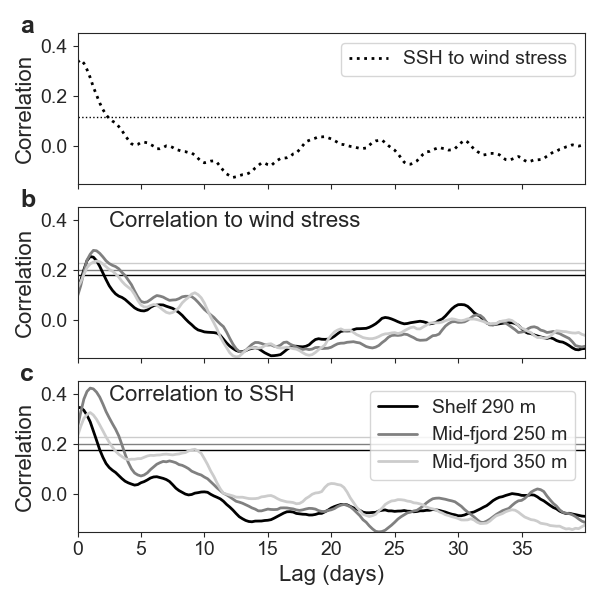

In [77]:
fig, ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(6, 6))
# sig1 = 2/(np.sqrt(forcor[data1].shape[0]-lag[minl]))

a1 = ax[0]
a1.tick_params(labelsize=14)
a1.set_facecolor('white')
# a1.grid(color='.9')
a1.plot(lagws, acws, c='k',linestyle=':',linewidth=2,label='SSH to wind stress')
a1.hlines(C95ws,0,lag,color='k',linestyle=':',linewidth=1)
a1.set_ylabel('Correlation',fontsize=16)
a1.set_ylim([-0.15,0.45])
a1.legend(fontsize=14,markerscale=2)
a1.text(-18,0.45,'a',weight='bold',fontsize=18)

a2 = ax[1]
a2.tick_params(labelsize=14)
a2.set_facecolor('white')
# a2.grid(color='.9')
a2.plot(lagwstsh, -acwstsh, c='k',linewidth=2,label='Shelf 290 m')
a2.hlines(C95wstsh,0,lag,color='k',linewidth=1)
a2.plot(lagwstm2, -acwstm2, c='0.5',linewidth=2,label='Mid-fjord 250 m')
a2.hlines(C95wstm2,0,lag,color='0.5',linewidth=1)
a2.plot(lagwstm3, -acwstm3, c='0.8',linewidth=2,label='Mid-fjord 400 m')
a2.hlines(C95wstm3,0,lag,color='0.8',linewidth=1)
a2.text(10,0.37,'Correlation to wind stress',fontsize=16)
a2.set_ylabel('Correlation',fontsize=16)
a2.set_ylim([-0.15,0.45])
# a2.legend(fontsize=12,markerscale=2)
a2.text(-18,0.45,'b',weight='bold',fontsize=18)

a3 = ax[2]
a3.tick_params(labelsize=14)
a3.set_facecolor('white')
# a3.grid(color='.9')
a3.plot(lagssh, -acssh, c='k',linewidth=2,label='Shelf 290 m')
a3.hlines(C95ssh,0,lag,color='k',linewidth=1)
a3.plot(lagsm2, -acsm2, c='0.5',linewidth=2,label='Mid-fjord 250 m')
a3.hlines(C95sm2,0,lag,color='0.5',linewidth=1)
a3.plot(lagsm3, -acsm3, c='0.8',linewidth=2,label='Mid-fjord 350 m')
a3.hlines(C95sm3,0,lag,color='0.8',linewidth=1)
a3.set_xlim([0,(40*4)])
a3.set_ylim([-0.15,0.45])
a3.set_xticks(np.arange(0,(40*4),5.0*4))
a3.set_xticklabels(np.arange(0,40,5))
a3.set_xlabel('Lag (days)',fontsize=16)
a3.set_ylabel('Correlation',fontsize=16)
a3.text(10,0.37,'Correlation to SSH',fontsize=16)
a3.legend(fontsize=14,markerscale=2)
a3.text(-18,0.45,'c',weight='bold',fontsize=18)

plt.tight_layout(h_pad=0.05)
plt.savefig('/Volumes/GoogleDrive/My Drive/User/Docs/PhD_Project/MODISWinds_Manuscript/Figures/CorrelFigWedof.jpg', format='jpg', dpi=400)
plt.show()

<IPython.core.display.Javascript object>


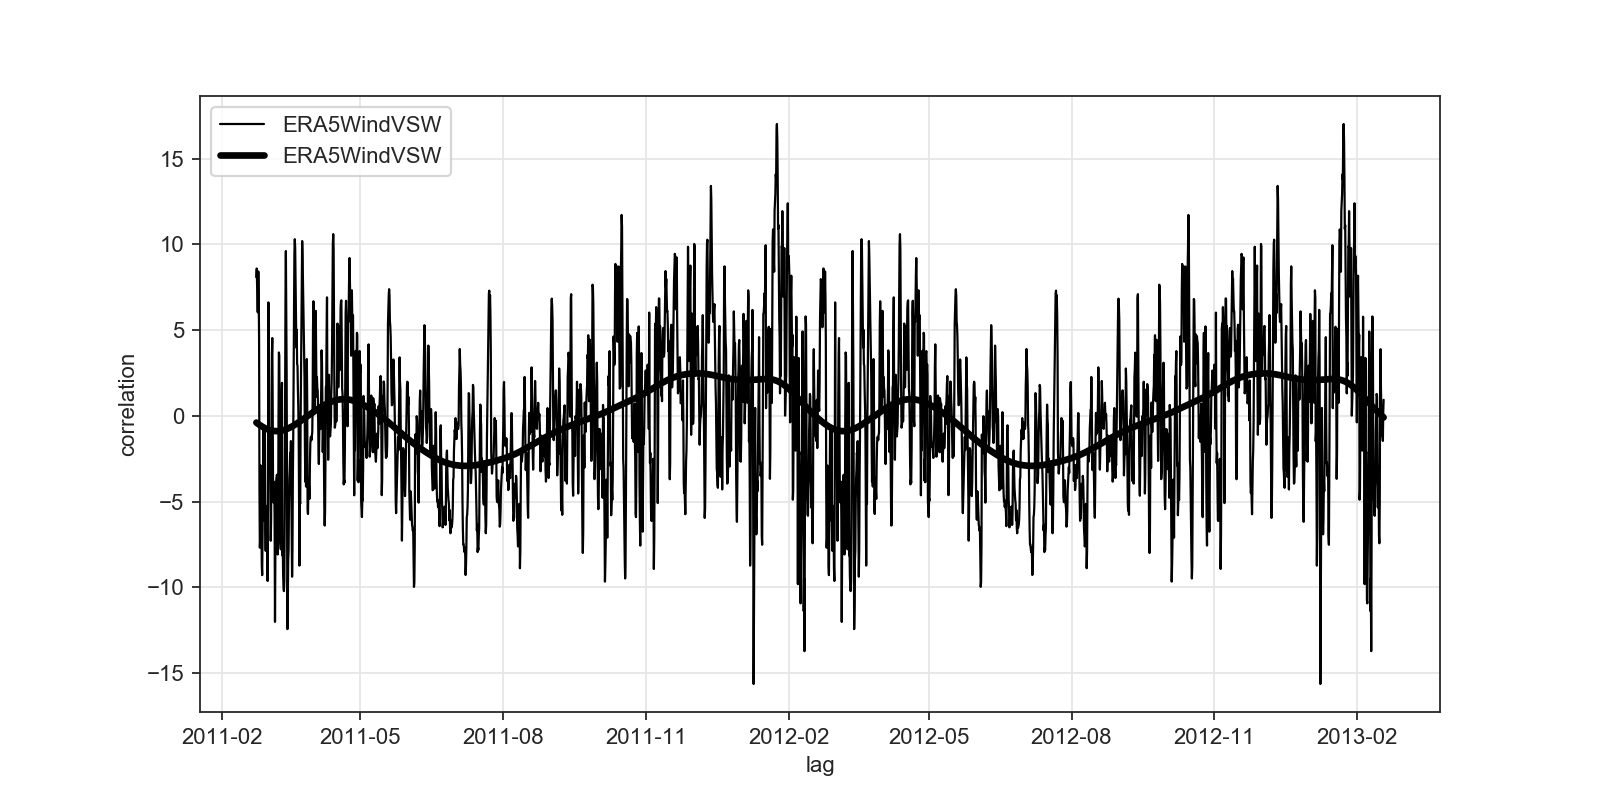

In [835]:
fig, ax = plt.subplots(figsize=(10, 5))
dataset = data2
ax.set_facecolor('white')
plt.grid(color='.9')
plt.plot(wsshd[dataset+'_seas'], c='k',linewidth=1,label=dataset)
plt.plot(wsshd[dataset+'_seasfilt'], c='k',linestyle='solid',linewidth=3,label=dataset)
# plt.xlim([0,1460])
plt.xlabel('lag')
plt.ylabel('correlation')
plt.legend()
plt.show()

In [677]:
# +h means y leads x
print ('Winds correlated with SSH')

data1 = 'SSH'
data2 = 'ERA5WindVSW'

wsshd = wssh[[data1,data2]].dropna()
lag, ac = autocorr(wsshd[data1], wsshd[data2], twosided=False, tapered=True)

# Max positive correlation index
maxl = lag[ac.argmax()]
minl = lag[ac.argmin()]

# 6 hr lag
print ('Max pos correlation and lag: '+str(round(ac[maxl],2))+', '+str(lag[maxl]*6)+' hrs')
print ('')

#############

print ('Shelf290 correlated with winds')

data1 = 'Tempshelf290m'
data2 = 'ERA5WindVSW'
cor=-1.0

wsshd = wssh[[data1,data2]].dropna()
result = seasonal_decompose(wsshd[data2],model='additive')
wsshd[data1+'_dt'] = result.resid.values
wsshd[data1+'_norm'] = (wsshd[data1+'_dt'] - wsshd[data1+'_dt'].mean())/wsshd[data1+'_dt'].std()

lag, ac = autocorr(wsshd[data1], wsshd[data2], twosided=False, tapered=True)

# Max positive and negative correlation index
maxl = lag[ac.argmax()]
minl = lag[ac.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(ac[maxl],2))+', '+str(lag[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(ac[minl],2))+', '+str(lag[minl]*6)+' hrs ('+str(lag[minl]/4)+'d)')
rng = [(i,e) for i,e in enumerate(ac) if e < cor] 
rng = [i for i in rng if i[0] < 200]
print ('Range with corrlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('')
print ('Pearsonr '+str(stats.pearsonr(stats.zscore(wsshd[data1]),stats.zscore(wsshd[data2]))))
print ('')

#############

print ('Mid250 correlated with SSH')

forcor = pd.concat([wssh['SSH'],midmoor['Tempmid250m']],axis=1).dropna()
data1 = 'Tempmid250m'
data2 = 'SSH'
cor=-0.3

lag, ac = autocorr(forcor[data1], forcor[data2], twosided=False, tapered=True)

# Max positive and negative correlation index
maxl = lag[ac.argmax()]
minl = lag[ac.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(ac[maxl],2))+', '+str(lag[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(ac[minl],2))+', '+str(lag[minl]*6)+' hrs ('+str(lag[minl]/4)+'d)')
rng = [(i,e) for i,e in enumerate(ac) if e < cor] 
rng = [i for i in rng if i[0] < 200]
print ('Range with corrlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print ('')

#############

print ('Mid400 correlated with SSH')

forcor = pd.concat([wssh['SSH'],midmoor['Tempmid400m']],axis=1).dropna()
data1 = 'Tempmid400m'
data2 = 'SSH'
cor=-0.3

lag, ac = autocorr(forcor[data1], forcor[data2], twosided=False, tapered=True)

# Max positive and negative correlation index
maxl = lag[ac.argmax()]
minl = lag[ac.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(ac[maxl],2))+', '+str(lag[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(ac[minl],2))+', '+str(lag[minl]*6)+' hrs ('+str(lag[minl]/4)+'d)')
rng = [(i,e) for i,e in enumerate(ac) if e < cor] 
rng = [i for i in rng if i[0] < 200]
print ('Range with corrlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print (str(abs(ac[minl])-(2/(np.sqrt(forcor[data1].shape[0]-lag[minl]))))) # Significant if positive
print ('')

#############
print ('Shelf290 correlated with SSH')

data1 = 'Tempshelf290m'
data2 = 'SSH'
cor=-0.25

wsshd = wssh[[data1,data2]].dropna()
lag, ac = autocorr(wsshd[data1], wsshd[data2], twosided=False, tapered=True)

# Max positive and negative correlation index
maxl = lag[ac.argmax()]
minl = lag[ac.argmin()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(ac[maxl],2))+', '+str(lag[maxl]*6)+' hrs')

# ~17-32 day lag
print ('Max neg correlation and lag: '+str(round(ac[minl],2))+', '+str(lag[minl]*6)+' hrs ('+str(lag[minl]/4)+'d)')
rng = [(i,e) for i,e in enumerate(ac) if e < cor] 
rng = [i for i in rng if i[0] < 200]
print ('Range with corrlation <'+str(cor)+': '+str(rng[0][0]*6)+'-'+str(rng[-1][0]*6)+' hrs ('+str(rng[0][0]/4)+'-'+str(rng[-1][0]/4)+'d)')
print (str(abs(ac[minl])-(2/(np.sqrt(wsshd[data1].shape[0]-lag[minl])))))
print ('')

#############

print ('Mid250 correlated with Shelf290')
data1 = 'Tempmid250m'
data2 = 'Tempshelf290m'

forcor = pd.concat([wssh[data2],midmoor[data1]],axis=1).dropna()
lag, ac = autocorr(forcor[data1], forcor[data2], twosided=False, tapered=True)

# Max positive and negative correlation index
maxl = lag[ac.argmax()]

# 1 day lag
print ('Max pos correlation and lag: '+str(round(ac[maxl],2))+', '+str(lag[maxl]*6)+' hrs')

Winds correlated with SSH
Max pos correlation and lag: 1.01, 6 hrs

Shelf290 correlated with winds
Max pos correlation and lag: 1.75, 24 hrs
Max neg correlation and lag: -1.53, 318 hrs (13d)
Range with corrlation <-1.0: 282-912 hrs (11-38d)

Pearsonr (-0.08285867206288369, 2.44005277651525e-10)

Mid250 correlated with SSH
Max pos correlation and lag: 1.36, 24 hrs
Max neg correlation and lag: -0.48, 570 hrs (23d)
Range with corrlation <-0.3: 414-768 hrs (17-32d)

Mid400 correlated with SSH
Max pos correlation and lag: 1.29, 24 hrs
Max neg correlation and lag: -0.53, 690 hrs (28d)
Range with corrlation <-0.3: 516-786 hrs (21-32d)
0.49612588529780094

Shelf290 correlated with SSH
Max pos correlation and lag: 1.02, 6 hrs
Max neg correlation and lag: -0.29, 444 hrs (18d)
Range with corrlation <-0.25: 408-732 hrs (17-30d)
0.26257527515427503

Mid250 correlated with Shelf290
Max pos correlation and lag: 1.02, 12 hrs


In [588]:
np.sqrt(wsshd[data2].shape[0])


76.28892449104261

In [495]:
# Max positive correlation
lag[ac.argmax()]
# ~1 day lag
# Tempshelf290,SSH - no filter
print (ac[74],lag[74]) # 0.29

# Max negative correlation ***
# ~18 day lag
# Tempshelf290,SSH - no filter
print (ac[74],lag[74]) # 0.29

# Tempshelf290,SSH - 3.125 d filter
print (ac[73],lag[73]) # 0.31

# Tempshelf290,SSH - 5 d filter
print (ac[72],lag[72]) #0.34

(-0.34061156626318995, 72)


In [411]:
# Correlation for adjusted SSTs and mooring temps
print ('Unfiltered',stats.pearsonr(stats.zscore(wsshd[data1]),stats.zscore(wsshd[data2])))


('Unfiltered', (nan, nan))


/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slic

In [412]:
wsshd[data1]

Series([], Freq: 6H, Name: SSH_filt, dtype: float64)